# Imports and configs

In [121]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif, f_classif, RFE, VarianceThreshold, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import optuna
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

In [122]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.float_format', '{:.2f}'.format)

In [123]:
data = pd.read_csv(r'./modelling_data/all_games_1819_2324_cleaned_new.csv')

# Basic data glimpse

In [95]:
data.shape

(37339, 170)

In [89]:
data.head()

attendance    home_team_name    away_team_name  game_week  \
0    13155.00      Austria Wien  Wacker Innsbruck       1.00   
1    10785.00        Sturm Graz          Hartberg       1.00   
2     4523.00  Rheindorf Altach       Mattersburg       1.00   
3    11532.00          Salzburg         LASK Linz       1.00   
4     5200.00            Admira        Rapid Wien       1.00   

   home_team_goal_count  away_team_goal_count  total_goal_count  \
0                     2                     1                 3   
1                     3                     2                 5   
2                     2                     3                 5   
3                     3                     1                 4   
4                     0                     3                 3   

   total_goals_at_half_time  home_team_goal_count_half_time  \
0                         2                               1   
1                         3                               2   
2                         2                               1   
3                         3                               3   
4                         3                               0   

   away_team_goal_count_half_time  home_team_corner_count  \
0                               1                       6   
1                               1                       7   
2                               1                       3   
3                               0                       4   
4                               3                       4   

   away_team_corner_count  home_team_yellow_cards  home_team_red_cards  \
0                       1                       1                    0   
1                       6                       3                    0   
2                       9                       4                    0   
3                       4                       1                    0   
4                       5                       2                    0   

   away_team_yellow_cards  away_team_red_cards  home_team_first_half_cards  \
0                       2                    0                           0   
1                       1                    0                           2   
2                       1                    0                           2   
3                       4                    0                           1   
4                       2                    0                           0   

   home_team_second_half_cards  away_team_first_half_cards  \
0                            1                           1   
1                            1                           0   
2                            2                           0   
3                            0                           1   
4                            2                           0   

   away_team_second_half_cards  home_team_shots  away_team_shots  \
0                            1               13                7   
1                            1               13                8   
2                            1               12                8   
3                            3               12                9   
4                            2                6               15   

   home_team_shots_on_target  away_team_shots_on_target  \
0                          8                          5   
1                          8                          4   
2                          4                          5   
3                          7                          5   
4                          5                          9   

   home_team_shots_off_target  away_team_shots_off_target  home_team_fouls  \
0                           5                           2                7   
1                           5                           4                9   
2                           8                           3               20   
3                           5                           4                8   
4                           

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37339 entries, 0 to 37338
Columns: 170 entries, attendance to average_draw_odds_by_away_team_in_last_5_games
dtypes: float64(113), int64(51), object(6)
memory usage: 48.4+ MB


In [7]:
data.groupby(['league', 'season']).apply(lambda x: x['game_week'].isna().sum())

league              season
austria             18/19     0
                    19/20     0
                    20/21     0
                    21/22     0
                    22/23     0
                    23/24     0
belgium pro league  18/19     0
                    19/20     0
                    20/21     0
                    21/22     0
                    22/23     0
                    23/24     0
bundesliga          18/19     0
                    19/20     0
                    20/21     0
                    21/22     0
                    22/23     0
                    23/24     0
czech first league  18/19     0
                    19/20     0
                    20/21     0
                    21/22     0
                    22/23     0
                    23/24     0
denmark             18/19     0
                    19/20     0
                    20/21     0
                    21/22     0
                    22/23     0
                    23/24     0
ekstraklasa  

In [8]:
data.dtypes

attendance                                                  float64
home_team_name                                               object
away_team_name                                               object
game_week                                                   float64
home_team_goal_count                                          int64
away_team_goal_count                                          int64
total_goal_count                                              int64
total_goals_at_half_time                                      int64
home_team_goal_count_half_time                                int64
away_team_goal_count_half_time                                int64
home_team_corner_count                                        int64
away_team_corner_count                                        int64
home_team_yellow_cards                                        int64
home_team_red_cards                                           int64
away_team_yellow_cards                          

# Feature engineering

In [134]:
#adding categorical feature with spring or autumn round during the season
data['round'] = pd.to_datetime(data['date']).apply(lambda x: 'spring' if x.month <= 6 else 'autumn')

In [135]:
data['time'] = pd.to_datetime(data['time'], format='%H:%M:%S').dt.time

#defining function to determine if time is 'day' or 'night'
def get_time_of_day(t):
    if t >= pd.Timestamp("06:00:00").time() and t < pd.Timestamp("18:00:00").time():
        return 'day'
    else:
        return 'night'

data['time_of_day'] = data['time'].apply(get_time_of_day)

In [136]:
data.shape

(36085, 172)

In [137]:
categorical_features = [
    'result',
    'league',
    'round',
    'time_of_day'
]
data[categorical_features] = data[categorical_features].astype('category')

In [138]:
data.shape

(36085, 172)

# Removing missing data

In [139]:
data['attendance'] = data['attendance'].replace({-1: 0})

In [125]:
cols_to_check_for_missing_values = [
    'home_team_goal_count',
    'away_team_goal_count',
    'total_goal_count',
    'total_goals_at_half_time',
    'home_team_goal_count_half_time',
    'away_team_goal_count_half_time',
    'home_team_corner_count',
    'away_team_corner_count',
    'home_team_yellow_cards',
    'home_team_red_cards',
    'away_team_yellow_cards',
    'away_team_red_cards',
    'home_team_first_half_cards',
    'home_team_second_half_cards',
    'away_team_first_half_cards',
    'away_team_second_half_cards',
    'home_team_shots',
    'away_team_shots',
    'home_team_shots_on_target',
    'away_team_shots_on_target',
    'home_team_shots_off_target',
    'away_team_shots_off_target',
    'home_team_fouls',
    'away_team_fouls',
    'home_team_possession',
    'away_team_possession'
]

In [126]:
rows_with_empties_in_stats = data[cols_to_check_for_missing_values].applymap(lambda x: x == -1).any(axis=1)

C:\Users\Łukasz\AppData\Local\Temp\ipykernel_33156\4074001773.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  rows_with_empties_in_stats = data[cols_to_check_for_missing_values].applymap(lambda x: x == -1).any(axis=1)


In [127]:
data = data[~rows_with_empties_in_stats]

In [133]:
data.shape

(36085, 170)

# Feature scaling

In [128]:
data.head()

attendance    home_team_name    away_team_name  game_week  \
0    13155.00      Austria Wien  Wacker Innsbruck       1.00   
1    10785.00        Sturm Graz          Hartberg       1.00   
2     4523.00  Rheindorf Altach       Mattersburg       1.00   
3    11532.00          Salzburg         LASK Linz       1.00   
4     5200.00            Admira        Rapid Wien       1.00   

   home_team_goal_count  away_team_goal_count  total_goal_count  \
0                     2                     1                 3   
1                     3                     2                 5   
2                     2                     3                 5   
3                     3                     1                 4   
4                     0                     3                 3   

   total_goals_at_half_time  home_team_goal_count_half_time  \
0                         2                               1   
1                         3                               2   
2                         2                               1   
3                         3                               3   
4                         3                               0   

   away_team_goal_count_half_time  home_team_corner_count  \
0                               1                       6   
1                               1                       7   
2                               1                       3   
3                               0                       4   
4                               3                       4   

   away_team_corner_count  home_team_yellow_cards  home_team_red_cards  \
0                       1                       1                    0   
1                       6                       3                    0   
2                       9                       4                    0   
3                       4                       1                    0   
4                       5                       2                    0   

   away_team_yellow_cards  away_team_red_cards  home_team_first_half_cards  \
0                       2                    0                           0   
1                       1                    0                           2   
2                       1                    0                           2   
3                       4                    0                           1   
4                       2                    0                           0   

   home_team_second_half_cards  away_team_first_half_cards  \
0                            1                           1   
1                            1                           0   
2                            2                           0   
3                            0                           1   
4                            2                           0   

   away_team_second_half_cards  home_team_shots  away_team_shots  \
0                            1               13                7   
1                            1               13                8   
2                            1               12                8   
3                            3               12                9   
4                            2                6               15   

   home_team_shots_on_target  away_team_shots_on_target  \
0                          8                          5   
1                          8                          4   
2                          4                          5   
3                          7                          5   
4                          5                          9   

   home_team_shots_off_target  away_team_shots_off_target  home_team_fouls  \
0                           5                           2                7   
1                           5                           4                9   
2                           8                           3               20   
3                           5                           4                8   
4                           

In [130]:
data_copy = data['home_team_goal_count']

In [131]:
data_copy

0        2
1        3
2        2
3        3
4        0
        ..
37333    0
37334    2
37335    0
37336    3
37337    0
Name: home_team_goal_count, Length: 36085, dtype: int64

In [132]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Sample DataFrame
# data = pd.DataFrame({
#     'feature': np.random.randn(100) * 100 + 20
# })

data_copy = data['home_team_goal_count']

# Standardization
scaler = StandardScaler()
data_copy['standardized'] = scaler.fit_transform(data_copy)

# Min-Max Normalization
min_max_scaler = MinMaxScaler()
data_copy['normalized'] = min_max_scaler.fit_transform(data_copy[['home_team_goal_count']])

# Robust Scaler
robust_scaler = RobustScaler()
data_copy['robust_scaled'] = robust_scaler.fit_transform(data_copy[['home_team_goal_count']])

# Arcsinh transformation
data_copy['arcsinh'] = np.arcsinh(data_copy['home_team_goal_count'])

# Plotting
fig, axs = plt.subplots(5, 1, figsize=(10, 8))
sns.histplot(data['feature'], ax=axs[0], kde=True, color='blue')
axs[0].set_title('Original Data')
sns.histplot(data['standardized'], ax=axs[1], kde=True, color='green')
axs[1].set_title('Standardized')
sns.histplot(data['normalized'], ax=axs[2], kde=True, color='red')
axs[2].set_title('Normalized')
sns.histplot(data['robust_scaled'], ax=axs[3], kde=True, color='purple')
axs[3].set_title('Robust Scaled')
sns.histplot(data['arcsinh'], ax=axs[4], kde=True, color='purple')
axs[4].set_title('Arcsin hyperbolic')
plt.tight_layout()
plt.show()


ValueError: Expected 2D array, got 1D array instead:
array=[2. 3. 2. ... 0. 3. 0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [12]:
def scale_data_arcsinh_std(df):
    num_features = df.select_dtypes(include='number').columns
    df[num_features] = np.arcsinh(df[num_features])
    df[num_features] = StandardScaler().fit_transform(df[num_features])
    return df

In [18]:
data = scale_data_arcsinh_std(data)

In [80]:
#conversion float64 and int64 to float32 and int32 to optimize computing
data[data.select_dtypes(include='float64').columns] = data[data.select_dtypes(include='float64').columns].astype('float32')
data[data.select_dtypes(include='int64').columns] = data[data.select_dtypes(include='int64').columns].astype('int32')

In [20]:
data.dtypes

attendance                                                   float32
home_team_name                                                object
away_team_name                                                object
game_week                                                    float32
home_team_goal_count                                         float32
away_team_goal_count                                         float32
total_goal_count                                             float32
total_goals_at_half_time                                     float32
home_team_goal_count_half_time                               float32
away_team_goal_count_half_time                               float32
home_team_corner_count                                       float32
away_team_corner_count                                       float32
home_team_yellow_cards                                       float32
home_team_red_cards                                          float32
away_team_yellow_cards            

# Feature selection

In [140]:
#dropping leaking and useless features
leaked_features_to_drop = [
    'home_team_name',
    'away_team_name',
    'home_team_goal_count',
    'away_team_goal_count',
    'total_goal_count',
    'total_goals_at_half_time',
    'home_team_goal_count_half_time',
    'away_team_goal_count_half_time',
    'home_team_corner_count',
    'away_team_corner_count',
    'home_team_yellow_cards',
    'home_team_red_cards',
    'away_team_yellow_cards',
    'away_team_red_cards',
    'home_team_first_half_cards',
    'home_team_second_half_cards',
    'away_team_first_half_cards',
    'away_team_second_half_cards',
    'home_team_shots',
    'away_team_shots',
    'home_team_shots_on_target',
    'away_team_shots_on_target',
    'home_team_shots_off_target',
    'away_team_shots_off_target',
    'home_team_fouls',
    'away_team_fouls',
    'home_team_possession',
    'away_team_possession',
    'home_team_xg',
    'away_team_xg',
    'corners_total',
    'yellow_cards_total',
    'red_cards_total',
    'cards_total',
    'shots_total',
    'shots_on_target_total',
    'shots_off_target_total',
    'fouls_total',
    'result',
    'date',
    'time',
    # 'league',
    'season'
]

In [141]:
#dropping info leaking features and targets
X = data.drop(leaked_features_to_drop, axis=1)

In [144]:
y = data['result'].astype(int)

In [147]:
X.shape, y.shape

((36085, 130), (36085,))

## Variance threshold

In [164]:
X[num_features].var().describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .99])

count         127.00
mean      1650209.78
std      18596270.00
min             0.01
10%             0.11
20%             0.18
30%             0.52
40%             1.92
50%             3.45
60%             7.95
70%            14.44
80%            43.66
90%           275.94
95%           398.72
99%           496.13
max     209569377.34
dtype: float64

In [168]:
median_variance = X[num_features].var().median()
median_variance

3.4476479952991124

In [169]:
from sklearn.feature_selection import VarianceThreshold

num_features = X.select_dtypes(include='number').columns

selector = VarianceThreshold(threshold=median_variance)
X_new = selector.fit_transform(X[num_features])

selected_features = X[num_features].columns[selector.get_support(indices=True)]
print("Wybrane cechy:", selected_features)

Wybrane cechy: Index(['attendance', 'game_week', 'btts_percentage_pre_match',
       'over_15_percentage_pre_match', 'over_25_percentage_pre_match',
       'over_35_percentage_pre_match', 'over_45_percentage_pre_match',
       'over_15_ht_fhg_percentage_pre_match',
       'over_05_ht_fhg_percentage_pre_match',
       'over_15_2hg_percentage_pre_match', 'over_05_2hg_percentage_pre_match',
       'average_corners_per_match_pre_match', 'odds_ft_home_team_win',
       'odds_ft_draw', 'odds_ft_away_team_win', 'odds_ft_over45',
       'home_team_cumulative_goals_scored_pre_game',
       'away_team_cumulative_goals_scored_pre_game',
       'home_team_cumulative_goals_conceded_pre_game',
       'away_team_cumulative_goals_conceded_pre_game',
       'home_team_average_corners_total_per_game_pre_game',
       'away_team_average_corners_total_per_game_pre_game',
       'home_team_average_shots_per_game_pre_game',
       'away_team_average_shots_per_game_pre_game',
       'home_team_average_fouls_

In [170]:
len(selected_features)

63

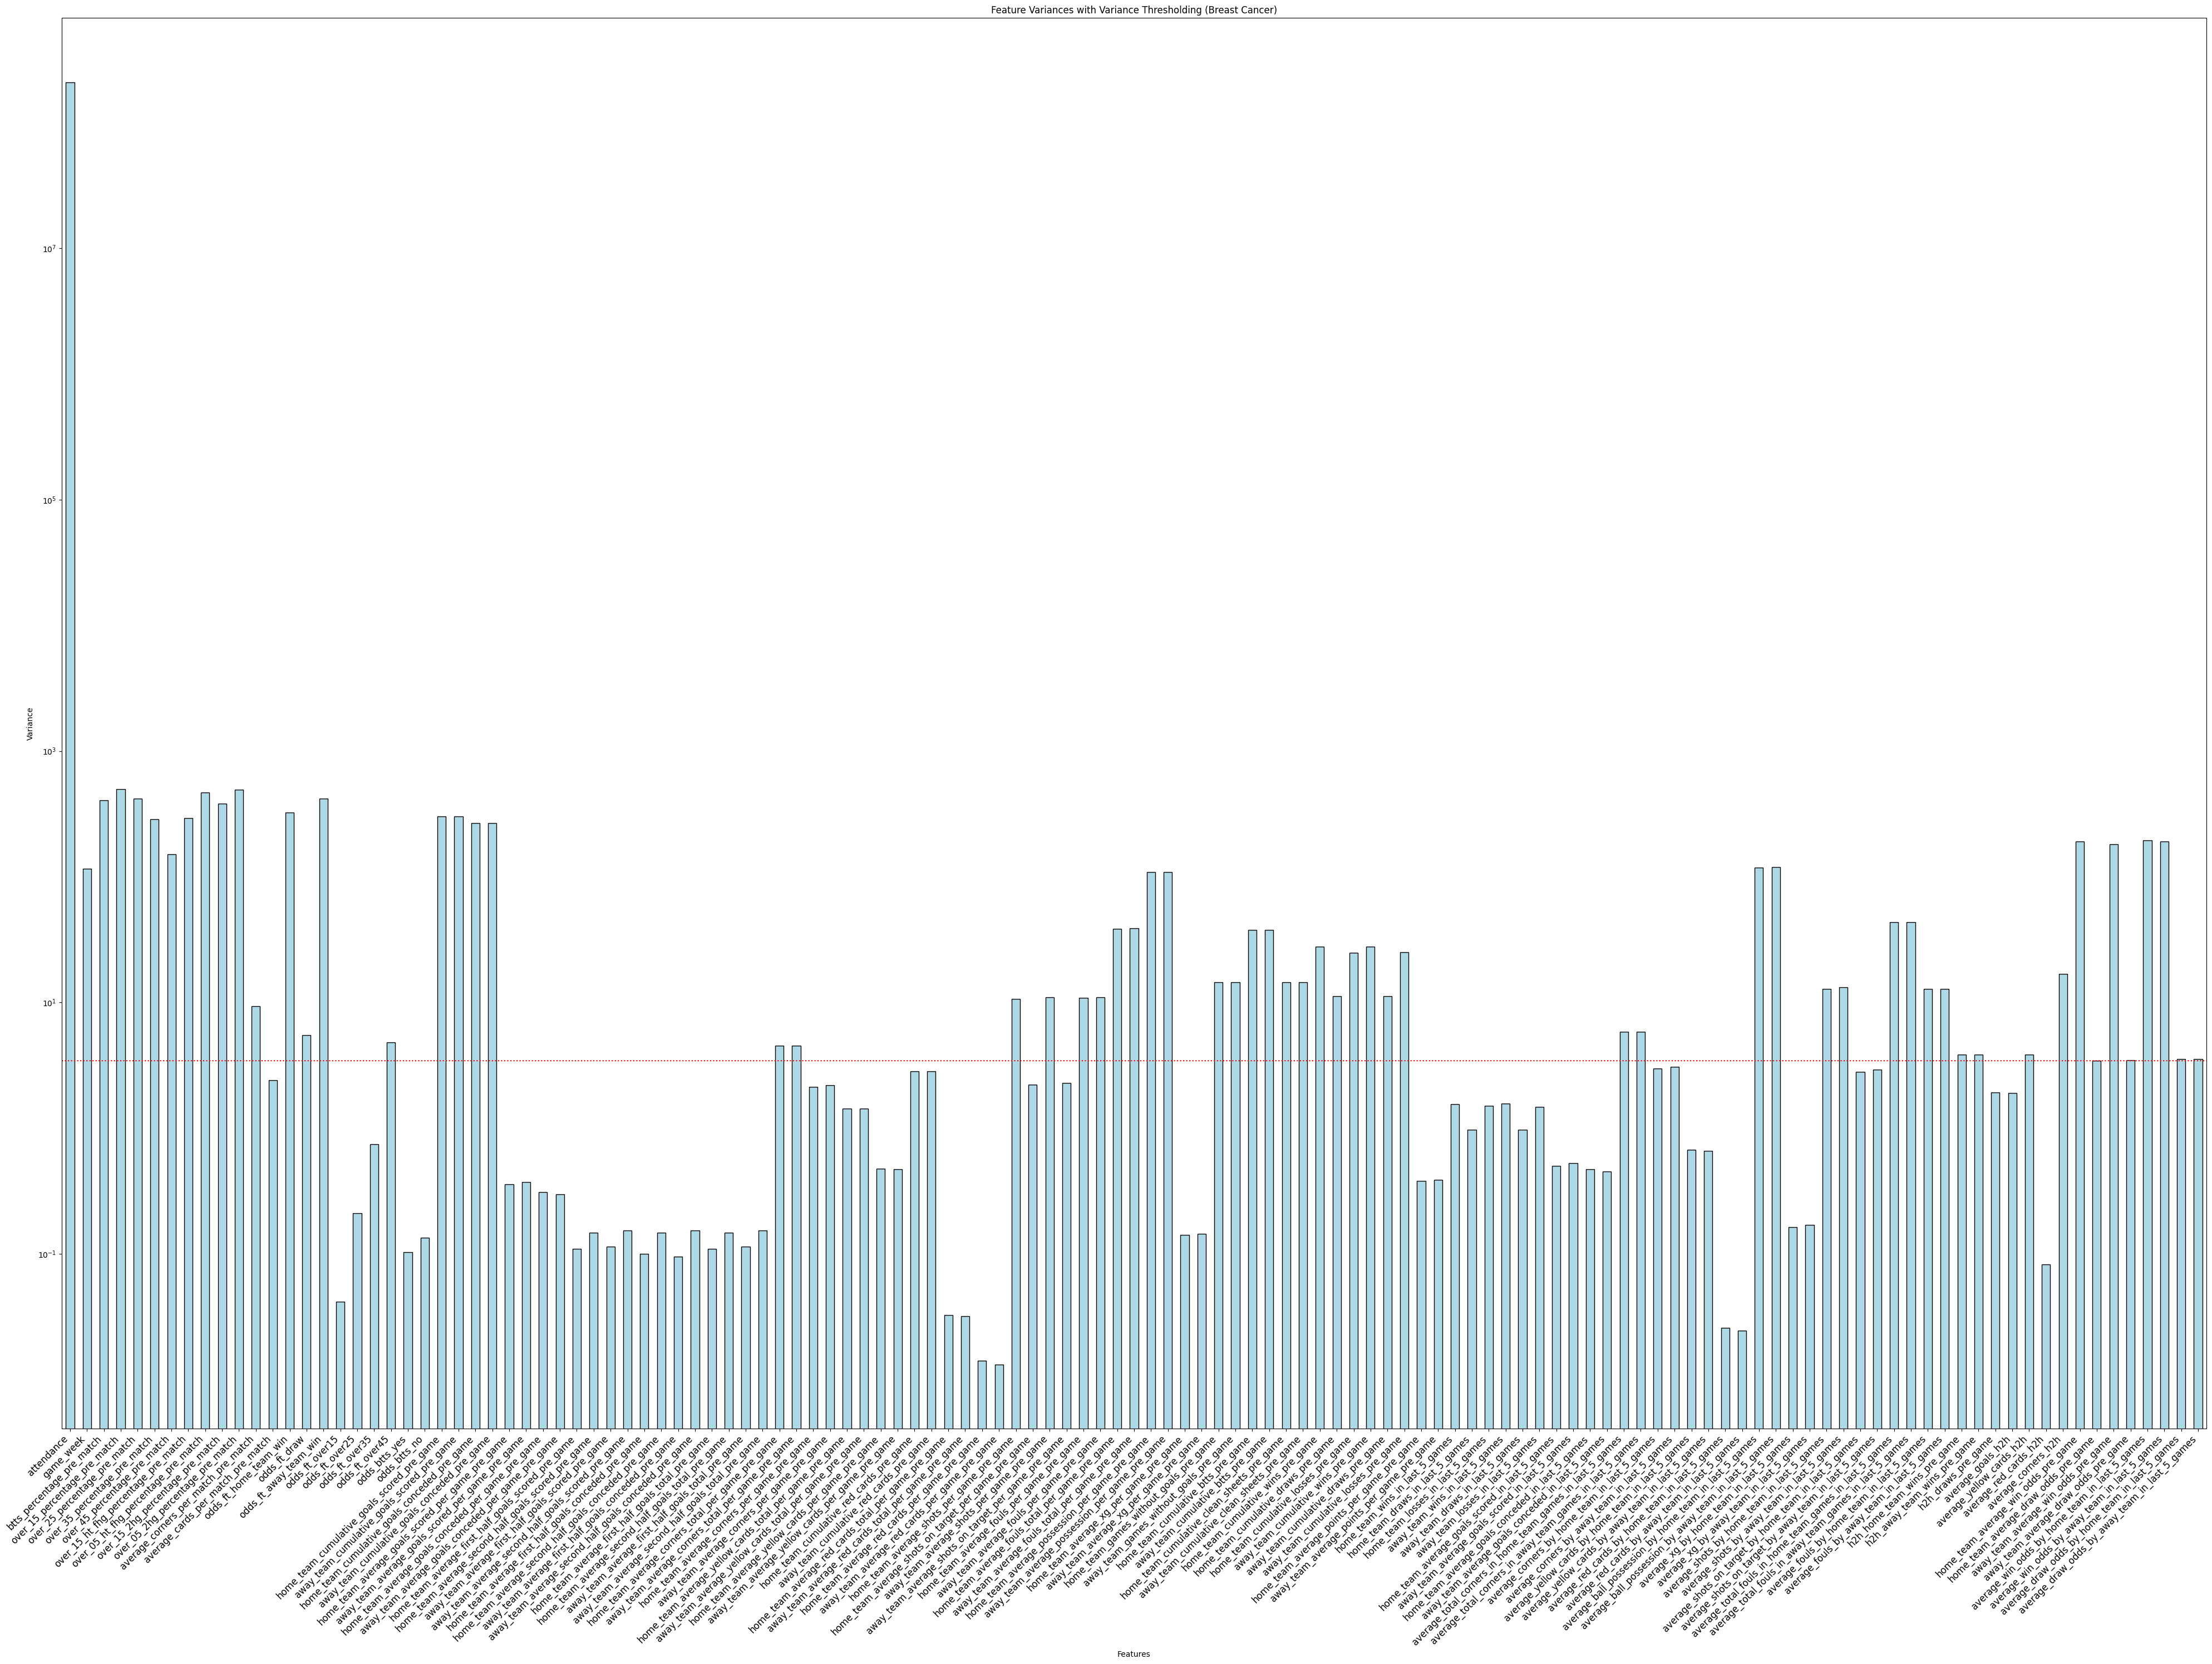

In [172]:
plt.figure(figsize=(40,30))
ax = pd.Series(X[num_features].var(), index=X[num_features].columns).plot(kind='bar', logy=True, color='lightblue', edgecolor='black')
ax.axhline(median_variance, ls='dotted', c='red')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.xlabel('Features')
plt.ylabel('Variance')
plt.title('Feature Variances with Variance Thresholding (Breast Cancer)')
plt.tight_layout()
plt.show()

## Pearson correlation

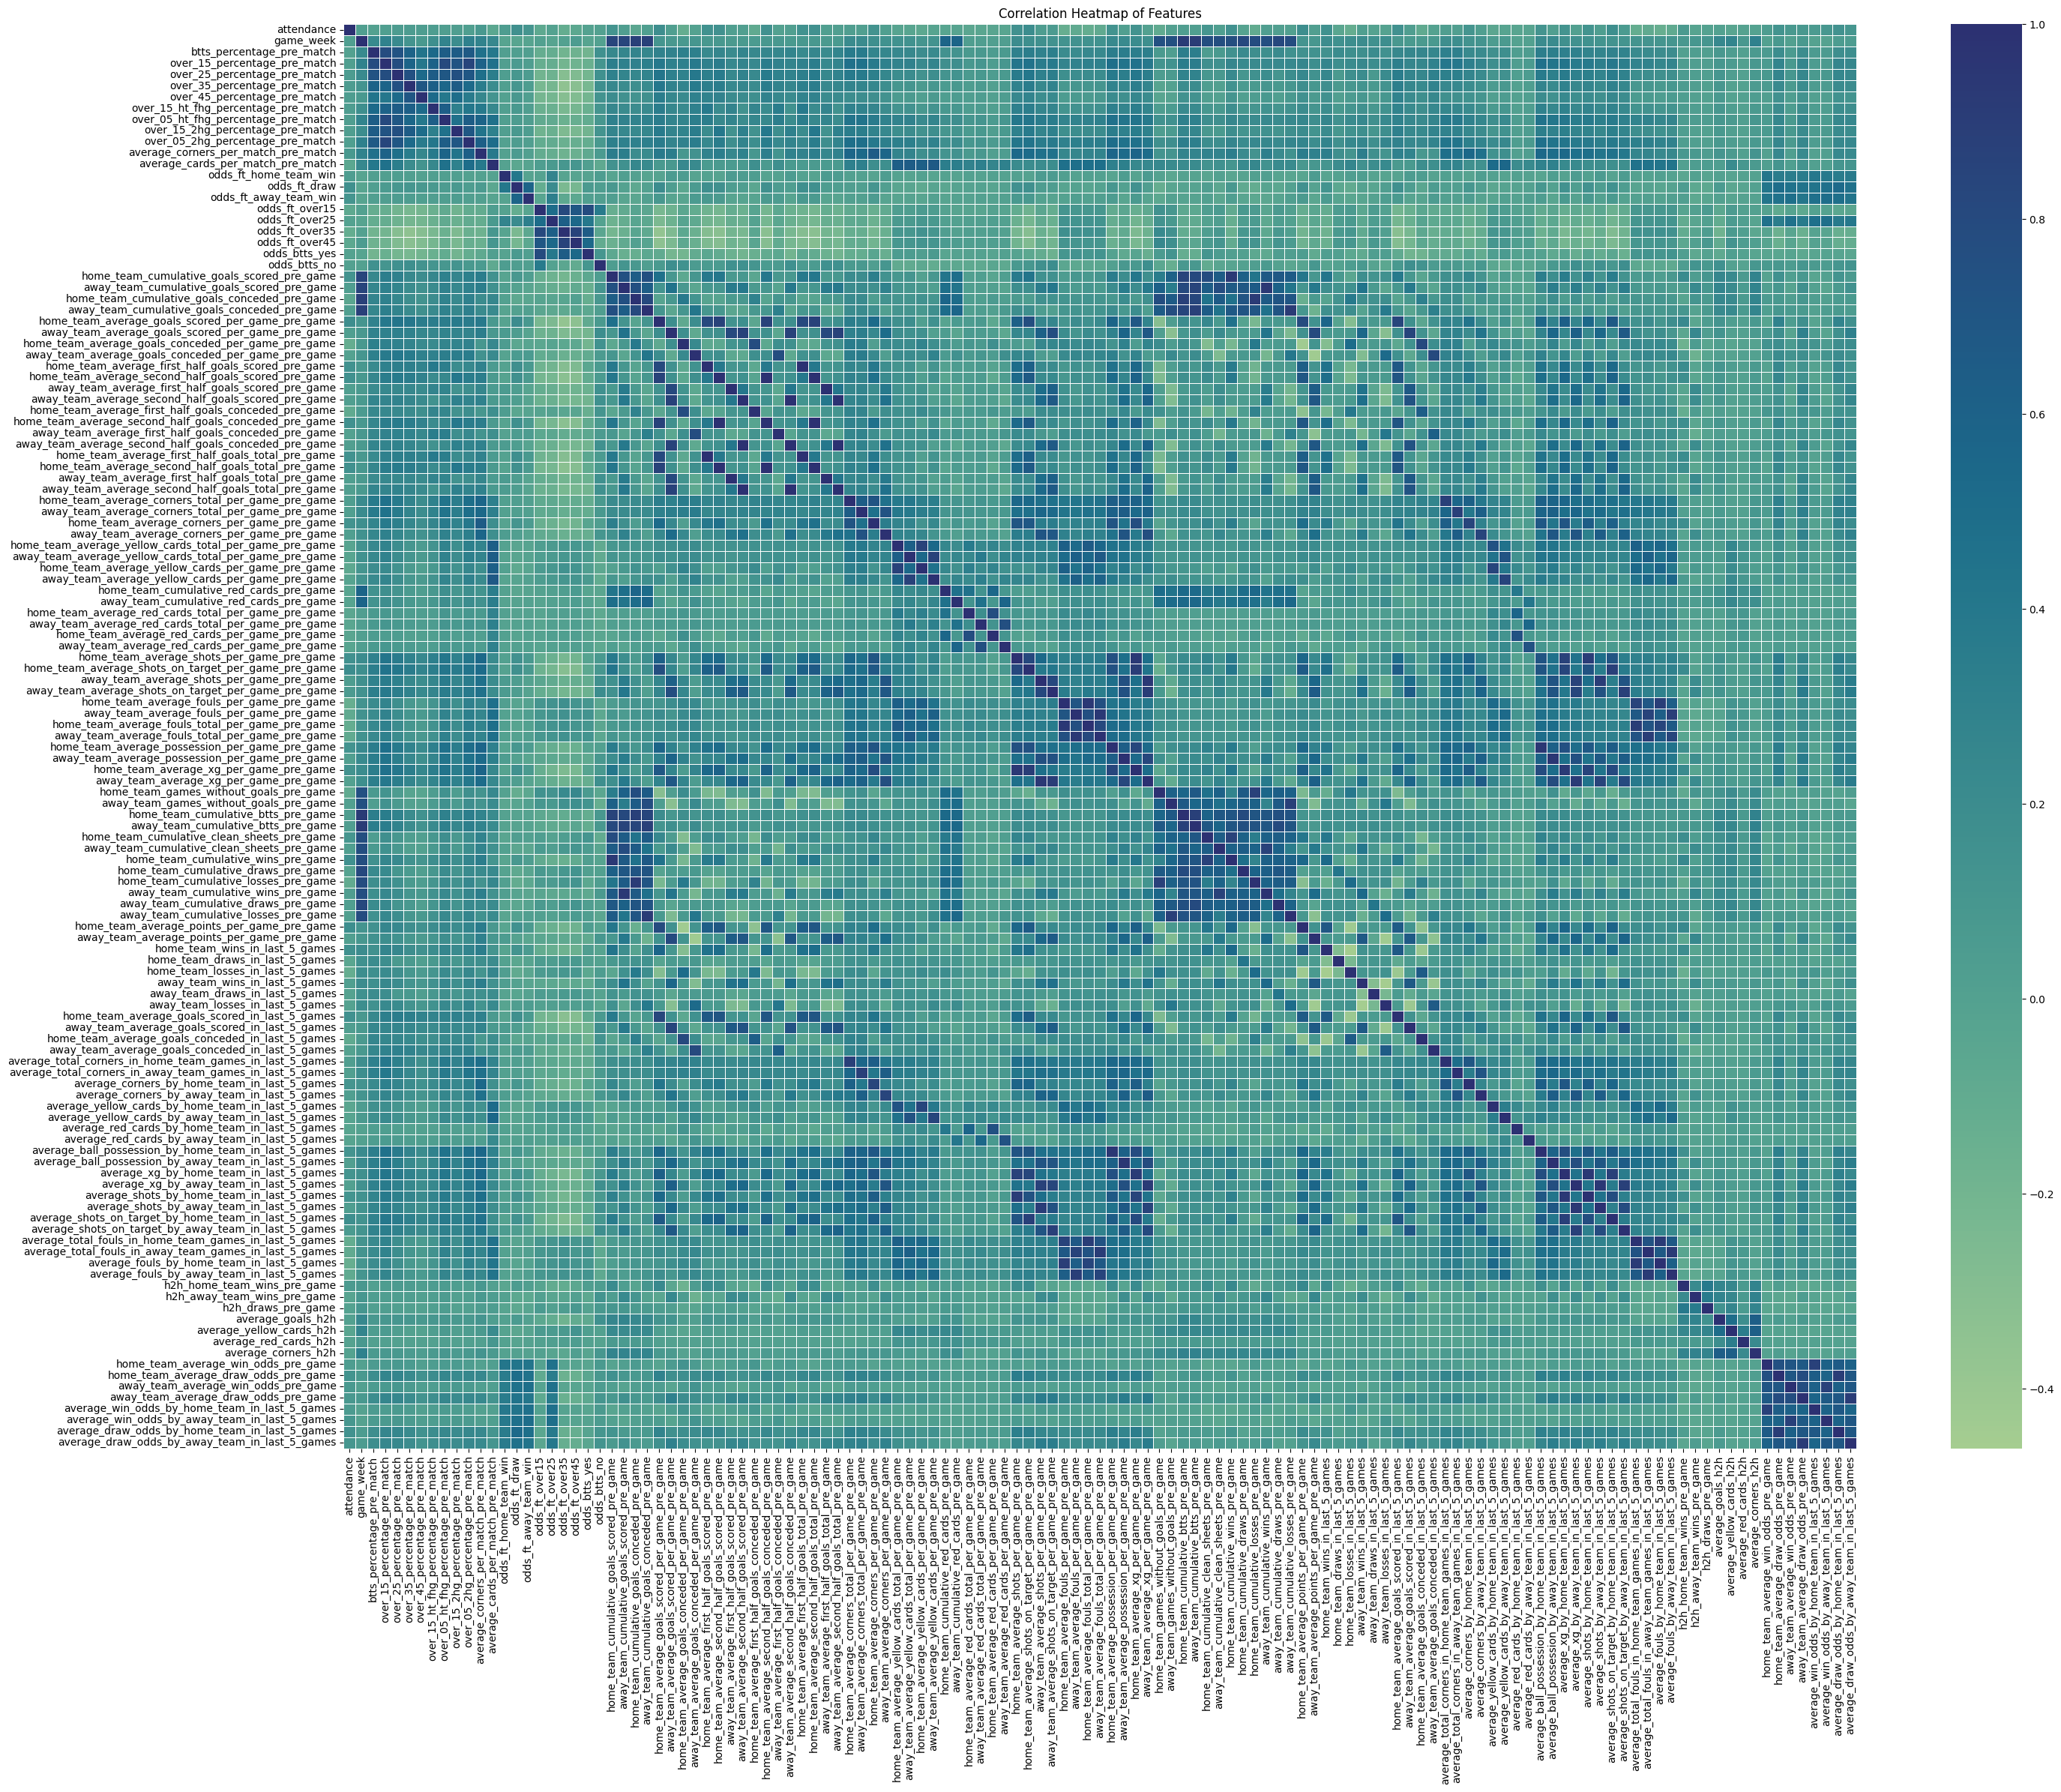

In [161]:
plt.figure(figsize=(30, 24))
corr_matrix = X[num_features].corr()

# Create a heatmap
sns.heatmap(corr_matrix, annot=False, cmap='crest', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## ANOVA

In [176]:
y = data['result']

In [177]:
selector = SelectKBest(score_func=f_classif, k='all')

In [179]:
X_anova = selector.fit_transform(X[num_features], y)

In [189]:
anova_results = pd.DataFrame(list(zip(X[num_features].columns, selector.scores_, selector.pvalues_)), columns=['feature', 'anova_f_score', 'p_value'])
anova_results

feature  anova_f_score  p_value
0                                           attendance         171.46     0.00
1                                            game_week           1.04     0.36
2                            btts_percentage_pre_match           0.41     0.67
3                         over_15_percentage_pre_match           8.21     0.00
4                         over_25_percentage_pre_match          17.59     0.00
5                         over_35_percentage_pre_match          19.94     0.00
6                         over_45_percentage_pre_match          15.02     0.00
7                  over_15_ht_fhg_percentage_pre_match           9.74     0.00
8                  over_05_ht_fhg_percentage_pre_match           5.98     0.00
9                     over_15_2hg_percentage_pre_match          16.92     0.00
10                    over_05_2hg_percentage_pre_match           8.09     0.00
11                 average_corners_per_match_pre_match          19.81     0.00
12                   average_cards_per_match_pre_match           5.19     0.01
13                               odds_ft_home_team_win         146.34     0.00
14                                        odds_ft_draw         189.71     0.00
15                               odds_ft_away_team_win         172.81     0.00
16                                      odds_ft_over15          70.67     0.00
17                                      odds_ft_over25          95.20     0.00
18                                      odds_ft_over35         153.19     0.00
19                                      odds_ft_over45         140.33     0.00
20                                       odds_btts_yes          26.01     0.00
21                                        odds_btts_no          44.79     0.00
22          home_team_cumulative_goals_scored_pre_game         200.56     0.00
23          away_team_cumulative_goals_scored_pre_game         180.62     0.00
24        home_team_cumulative_goals_conceded_pre_game          99.11     0.00
25        away_team_cumulative_goals_conceded_pre_game         127.53     0.00
26    home_team_average_goals_scored_per_game_pre_game         532.67     0.00
27    away_team_average_goals_scored_per_game_pre_game         524.43     0.00
28   home_team_average_goals_conceded_per_game_pre_...         343.95     0.00
29   away_team_average_goals_conceded_per_game_pre_...         355.70     0.00
30   home_team_average_first_half_goals_scored_pre_...         353.99     0.00
31   home_team_average_second_half_goals_scored_pre...         380.79     0.00
32   away_team_average_first_half_goals_scored_pre_...         369.16     0.00
33   away_team_average_second_half_goals_scored_pre...         362.56     0.00
34   home_team_average_first_half_goals_conceded_pr...         214.07     0.00
35   home_team_average_second_half_goals_conceded_p...         380.79     0.00
36   away_team_average_first_half_goals_conceded_pr...         192.04     0.00
37   away_team_average_second_half_goals_conceded_p...         362.56     0.00
38   home_team_average_first_half_goals_total_pre_game         353.99     0.00
39   home_team_average_second_half_goals_total_pre_...         380.79     0.00
40   away_team_average_first_half_goals_total_pre_game         369.16     0.00
41   away_team_average_second_half_goals_total_pre_...         362.56     0.00
42   home_team_average_corners_total_per_game_pre_game           3.53     0.03
43   away_team_average_corners_total_per_game_pre_game           0.83     0.44
44         home_team_average_corners_per_game_pre_game         339.43     0.00
45         away_team_average_corners_per_game_pre_game         300.95     0.00
46   home_team_average_yellow_cards_total_per_game_...           5.27     0.01
47   away_team_average_yellow_cards_total_per_game_...           5.48     0.00
48    home_team_average_yellow_cards_per_game_pre_game          50.11     0.00
49    away_team_average_yellow_cards_per_game_pre_game          59.09     0.00
50             hom

In [186]:
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = X[num_features].iloc[:, selected_feature_indices].columns

In [187]:
feature_names = X[num_features].columns

In [191]:
median_anova = anova_results['anova_f_score'].median()
median_anova

140.33391394627816

In [ ]:
plt.figure(figsize=(40,30))
ax = pd.Series(X[num_features].var(), index=X[num_features].columns).plot(kind='bar', logy=True, color='lightblue', edgecolor='black')
ax.axhline(median_variance, ls='dotted', c='red')

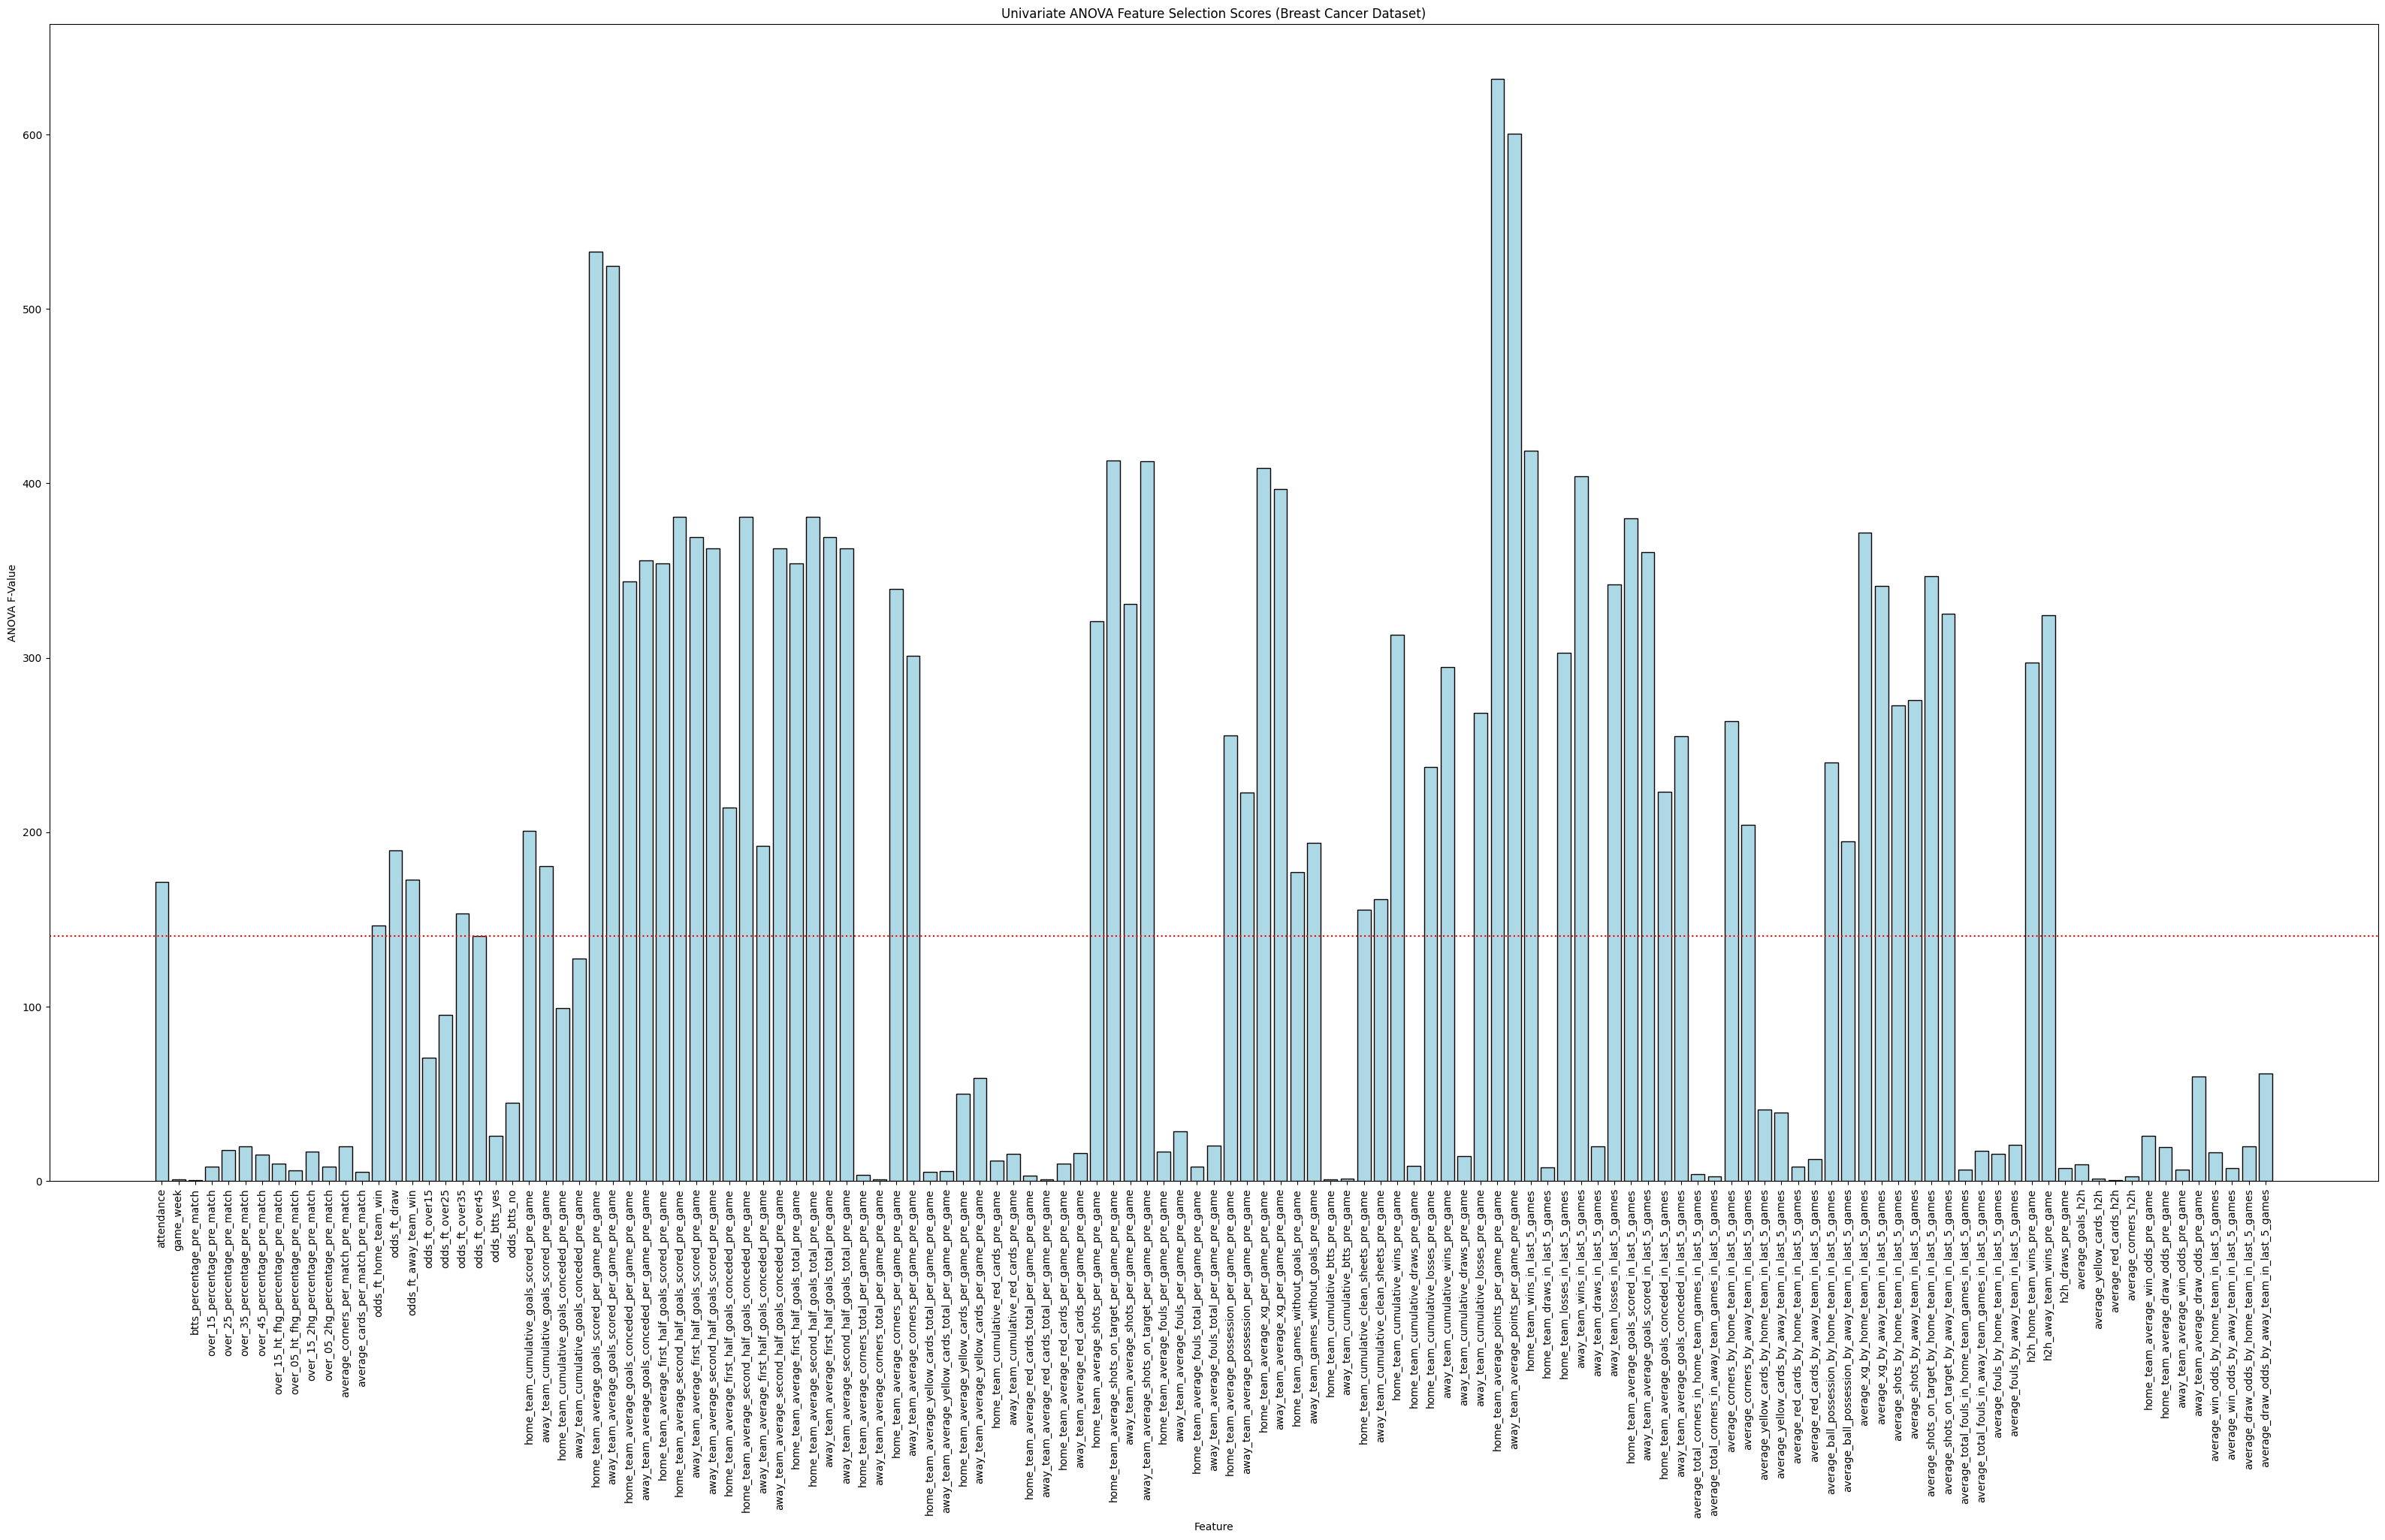

In [194]:
plt.figure(figsize=(40, 20))
plt.bar(range(len(feature_names)), selector.scores_, tick_label=feature_names, color='lightblue', edgecolor='black')
plt.axhline(median_anova, ls='dotted', c='red')
plt.xlabel('Feature')
plt.ylabel('ANOVA F-Value')
plt.title('Univariate ANOVA Feature Selection Scores (Breast Cancer Dataset)')
plt.xticks(rotation=90)
plt.show()

## Variance Inflation Factor (VIF)

In [195]:
X = sm.add_constant(X)

In [196]:
vif_df = pd.DataFrame()

In [197]:
vif_df['feature'] = X[num_features].columns

In [198]:
vif_df['VIF'] = [variance_inflation_factor(X[num_features].values, i) for i in range(X[num_features].shape[1])]

c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [199]:
vif_df

feature     VIF
0                                           attendance    2.52
1                                            game_week  312.52
2                            btts_percentage_pre_match   30.17
3                         over_15_percentage_pre_match  114.35
4                         over_25_percentage_pre_match   41.38
5                         over_35_percentage_pre_match   15.69
6                         over_45_percentage_pre_match    5.54
7                  over_15_ht_fhg_percentage_pre_match   16.54
8                  over_05_ht_fhg_percentage_pre_match   50.38
9                     over_15_2hg_percentage_pre_match   31.06
10                    over_05_2hg_percentage_pre_match   66.70
11                 average_corners_per_match_pre_match   40.92
12                   average_cards_per_match_pre_match   33.34
13                               odds_ft_home_team_win    1.93
14                                        odds_ft_draw   10.26
15                               odds_ft_away_team_win    2.59
16                                      odds_ft_over15  418.59
17                                      odds_ft_over25   60.82
18                                      odds_ft_over35  137.15
19                                      odds_ft_over45   30.40
20                                       odds_btts_yes  125.73
21                                        odds_btts_no   80.38
22          home_team_cumulative_goals_scored_pre_game  129.07
23          away_team_cumulative_goals_scored_pre_game  127.32
24        home_team_cumulative_goals_conceded_pre_game  130.65
25        away_team_cumulative_goals_conceded_pre_game  132.08
26    home_team_average_goals_scored_per_game_pre_game     inf
27    away_team_average_goals_scored_per_game_pre_game     inf
28   home_team_average_goals_conceded_per_game_pre_...   73.08
29   away_team_average_goals_conceded_per_game_pre_...   75.08
30   home_team_average_first_half_goals_scored_pre_...     inf
31   home_team_average_second_half_goals_scored_pre...     inf
32   away_team_average_first_half_goals_scored_pre_...     inf
33   away_team_average_second_half_goals_scored_pre...     inf
34   home_team_average_first_half_goals_conceded_pr...   13.03
35   home_team_average_second_half_goals_conceded_p...     inf
36   away_team_average_first_half_goals_conceded_pr...   13.62
37   away_team_average_second_half_goals_conceded_p...     inf
38   home_team_average_first_half_goals_total_pre_game     inf
39   home_team_average_second_half_goals_total_pre_...     inf
40   away_team_average_first_half_goals_total_pre_game     inf
41   away_team_average_second_half_goals_total_pre_...     inf
42   home_team_average_corners_total_per_game_pre_game  226.01
43   away_team_average_corners_total_per_game_pre_game  227.86
44         home_team_average_corners_per_game_pre_game  133.78
45         away_team_average_corners_per_game_pre_game  134.12
46   home_team_average_yellow_cards_total_per_game_...   81.45
47   away_team_average_yellow_cards_total_per_game_...   80.21
48    home_team_average_yellow_cards_per_game_pre_game   80.59
49    away_team_average_yellow_cards_per_game_pre_game   81.85
50             home_team_cumulative_red_cards_pre_game    6.03
51             away_team_cumulative_red_cards_pre_game    6.26
52   home_team_average_red_cards_total_per_game_pre...    6.30
53   away_team_average_red_cards_total_per_game_pre...    5.92
54       home_team_average_red_cards_per_game_pre_game    8.26
55       away_team_average_red_cards_per_game_pre_game    8.14
56           home_team_average_shots_per_game_pre_game  864.13
57   home_team_average_shots_on_target_per_game_pre...  307.13
58           away_team_average_shots_per_game_pre_game  869.67
59   away_team_average_shots_on_target_per_game_pre...  307.53
60           home_team_average_fouls_per_game_pre_game  369.87
61           away_team_average_fouls_per_game_pre_game  368.27
62     home_team_average_fouls_total_per_game_pre_game  517.93
63     away_tea

In [200]:
vif_df[vif_df['VIF'] <= 10]

feature  VIF
0                                           attendance 2.52
6                         over_45_percentage_pre_match 5.54
13                               odds_ft_home_team_win 1.93
15                               odds_ft_away_team_win 2.59
50             home_team_cumulative_red_cards_pre_game 6.03
51             away_team_cumulative_red_cards_pre_game 6.26
52   home_team_average_red_cards_total_per_game_pre... 6.30
53   away_team_average_red_cards_total_per_game_pre... 5.92
54       home_team_average_red_cards_per_game_pre_game 8.26
55       away_team_average_red_cards_per_game_pre_game 8.14
98      average_red_cards_by_home_team_in_last_5_games 3.21
99      average_red_cards_by_away_team_in_last_5_games 3.12
112                        h2h_home_team_wins_pre_game 2.49
113                        h2h_away_team_wins_pre_game 2.55
114                                 h2h_draws_pre_game 2.36
115                                  average_goals_h2h 7.65
116                           average_yellow_cards_h2h 9.01
117                              average_red_cards_h2h 1.51
119                home_team_average_win_odds_pre_game 9.70
123      average_win_odds_by_home_team_in_last_5_games 7.21
124      average_win_odds_by_away_team_in_last_5_games 6.96

## Mutual information

In [53]:
features_scores = mutual_info_classif(X[num_features], y, random_state=42)

In [54]:
pd.DataFrame(dict(zip(num_features, features_scores)), index=['mutual_info_score']).T.sort_values(by='mutual_info_score', ascending=False)

mutual_info_score
odds_ft_home_team_win                                        0.098469
home_team_shots_on_target                                    0.092151
odds_ft_away_team_win                                        0.089529
away_team_shots_on_target                                    0.081297
away_team_xg                                                 0.035011
away_team_average_win_odds_pre_game                          0.031711
home_team_average_win_odds_pre_game                          0.031281
away_team_shots                                              0.031197
home_team_xg                                                 0.029218
average_win_odds_by_home_team_in_last_5_games                0.026211
home_team_shots                                              0.024973
average_win_odds_by_away_team_in_last_5_games                0.024880
home_team_average_points_per_game_pre_game                   0.023492
away_team_average_points_per_game_pre_game                   0.022653
odds_ft_draw                                                 0.022405
away_team_average_shots_on_target_per_game_pre_...           0.022178
away_team_average_second_half_goals_total_pre_game           0.021139
home_team_average_shots_on_target_per_game_pre_...           0.021038
average_shots_on_target_by_home_team_in_last_5_...           0.020669
home_team_average_possession_per_game_pre_game               0.020542
away_team_average_goals_scored_per_game_pre_game             0.019888
home_team_average_xg_per_game_pre_game                       0.019336
away_team_average_shots_per_game_pre_game                    0.019129
average_ball_possession_by_home_team_in_last_5_...           0.019061
away_team_average_possession_per_game_pre_game               0.018974
home_team_average_goals_scored_per_game_pre_game             0.018117
away_team_average_xg_per_game_pre_game                       0.017900
home_team_average_second_half_goals_conceded_pr...           0.017051
average_shots_by_home_team_in_last_5_games                   0.016830
average_ball_possession_by_away_team_in_last_5_...           0.016170
average_xg_by_home_team_in_last_5_games                      0.015763
home_team_average_goals_conceded_per_game_pre_game           0.015753
home_team_average_corners_per_game_pre_game                  0.015722
home_team_average_first_half_goals_scored_pre_game           0.015639
away_team_average_second_half_goals_scored_pre_...           0.015582
average_xg_by_away_team_in_last_5_games                      0.015485
away_team_average_goals_conceded_per_game_pre_game           0.015454
home_team_average_second_half_goals_total_pre_game           0.015174
home_team_average_second_half_goals_scored_pre_...           0.014648
away_team_average_first_half_goals_scored_pre_game           0.014540
home_team_average_goals_scored_in_last_5_games               0.014203
h2h_home_team_wins_pre_game                                  0.014125
away_team_average_second_half_goals_conceded_pr...           0.013781
away_team_average_first_half_goals_conceded_pre...           0.013638
average_draw_odds_by_away_team_in_last_5_games               0.013604
away_team_average_corners_per_game_pre_game                  0.013567
average_corners_by_home_team_in_last_5_games                 0.012604
away_team_wins_in_last_5_games                               0.012408
average_shots_by_away_team_in_last_5_games                   0.012281
average_draw_odds_by_home_team_in_last_5_games               0.012145
away_team_cumulative_clean_sheets_pre_game                   0.012006
away_team_average_draw_odds_pre_game                         0.011805
home_team_red_cards                                          0.011598
home_team_average_shots_per_game_pre_game                    0.010790
odds_ft_over45                                               0.010582
attendance                                                   0.010572
away_team_cumulative_goals_scored_pre_game                   0

## Wrapper methods

### RFE

In [34]:
X

attendance  game_week  home_team_corner_count  away_team_corner_count  \
0            0.35      -2.95                    0.41                   -1.72   
1            0.28      -2.95                    0.65                    0.68   
2           -0.03      -2.95                   -0.66                    1.28   
3            0.30      -2.95                   -0.22                    0.09   
4            0.02      -2.95                   -0.22                    0.42   
...           ...        ...                     ...                     ...   
37333       -0.23       0.88                    1.05                   -0.88   
37334       -0.23       0.88                    0.12                    0.68   
37335       -0.23       0.88                   -0.22                   -0.88   
37336       -0.23       0.88                    0.41                   -0.32   
37337       -0.23       0.88                   -0.22                    0.09   

       home_team_yellow_cards  home_team_red_cards  away_team_yellow_cards  \
0                       -0.53                -0.30                    0.15   
1                        0.88                -0.30                   -0.72   
2                        1.30                -0.30                   -0.72   
3                       -0.53                -0.30                    1.16   
4                        0.32                -0.30                    0.15   
...                       ...                  ...                     ...   
37333                   -0.53                -0.30                    0.15   
37334                   -0.53                -0.30                   -0.72   
37335                   -0.53                -0.30                   -0.72   
37336                    0.32                -0.30                   -0.72   
37337                   -0.53                -0.30                   -0.72   

       away_team_red_cards  home_team_first_half_cards  \
0                    -0.33                       -0.92   
1                    -0.33                        1.59   
2                    -0.33                        1.59   
3                    -0.33                        0.61   
4                    -0.33                       -0.92   
...                    ...                         ...   
37333                -0.33                       -0.92   
37334                -0.33                       -0.92   
37335                -0.33                        0.61   
37336                -0.33                       -0.92   
37337                -0.33                       -0.92   

       home_team_second_half_cards  away_team_first_half_cards  \
0                            -0.07                        0.47   
1                            -0.07                       -1.01   
2                             0.77                       -1.01   
3                            -1.37                        0.47   
4                             0.77                       -1.01   
...                            ...                         ...   
37333                        -0.07                        0.47   
37334                        -0.07                       -1.01   
37335                        -1.37                        0.47   
37336                         0.77                       -1.01   
37337                        -0.07                       -1.01   

       away_team_second_half_cards  home_team_shots  away_team_shots  \
0                            -0.20             0.20            -0.78   
1                            -0.20             0.20            -0.49   
2                            -0.20             0.01            -0.49   
3                             1.19             0.01            -0.23   
4                             0.64            -1.63             0.89   
...                            ...              ...              ...   
37333                        -0.20             0.01             0.00   
37334                        -0.20         

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
model = LogisticRegression(solver='liblinear', multi_class='ovr')

In [99]:
total_features = X_train.shape[1]
rfe = RFE(model, n_features_to_select=total_features)

# Fit the RFE to the training data
rfe.fit(X_train, y_train)

RFE(estimator=LogisticRegression(multi_class='ovr', solver='liblinear'),
    n_features_to_select=157)

In [100]:
ranking = rfe.ranking_

In [102]:
num_irrelevant_features_eliminated = np.arange(total_features - 1, -1, -1)

In [103]:
accuracy_list = []
for i in num_irrelevant_features_eliminated:
    rfe = RFE(model, n_features_to_select=(total_features - i))
    rfe.fit(X_train, y_train)
    y_pred = rfe.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)

plt.figure(figsize=(8, 6))
plt.plot(num_irrelevant_features_eliminated, accuracy_list, marker='o')
plt.xlabel("Number of Irrelevant Features Eliminated")
plt.ylabel("Accuracy")
plt.title("Model Performance as Irrelevant Features are Eliminated (RFE)")
plt.grid(True)
plt.show()

## Summary

# Result prediction

## Random forest

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

### Base

In [56]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)

In [57]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, random_state=42)

In [58]:
y_pred = rf_model.predict(X_test)

In [59]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.03      0.07      1951
           1       0.53      0.90      0.67      3268
           2       0.57      0.47      0.52      2249

    accuracy                           0.54      7468
   macro avg       0.66      0.47      0.42      7468
weighted avg       0.63      0.54      0.46      7468



### Hyperparameters tuning with optuna

In [168]:
def objective(trial):
    # Number of trees in random forest
    n_estimators = trial.suggest_int(name="n_estimators", low=100, high=500, step=100)

    # Number of features to consider at every split
    max_features = trial.suggest_categorical(name="max_features", choices=['sqrt', 'log2', None]) 

    # Maximum number of levels in tree
    max_depth = trial.suggest_int(name="max_depth", low=10, high=110, step=20)

    # Minimum number of samples required to split a node
    min_samples_split = trial.suggest_int(name="min_samples_split", low=2, high=10, step=2)

    # Minimum number of samples required at each leaf node
    min_samples_leaf = trial.suggest_int(name="min_samples_leaf", low=1, high=4, step=1)
    
    params = {
        "n_estimators": n_estimators,
        "max_features": max_features,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf
    }
    model = RandomForestClassifier(random_state=42, **params)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    # cv_score = cross_val_score(model, X_train, y_train, n_jobs=4, cv=5)
    # mean_cv_accuracy = cv_score.mean()
    return acc

In [169]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

[I 2024-07-13 16:38:31,007] A new study created in memory with name: no-name-8088fcba-2a49-4459-9989-09039185b482
[W 2024-07-13 16:40:11,421] Trial 0 failed with parameters: {'n_estimators': 400, 'max_features': None, 'max_depth': 110, 'min_samples_split': 6, 'min_samples_leaf': 3} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Łukasz\AppData\Local\Temp\ipykernel_31148\3511437812.py", line 26, in objective
    model.fit(X_train, y_train)
  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\sklearn\ensemble\_forest.py

KeyboardInterrupt: 

## XGBoost

const  attendance  game_week  btts_percentage_pre_match  \
0       1.00    13155.00       1.00                          0   
1       1.00    10785.00       1.00                          0   
2       1.00     4523.00       1.00                          0   
3       1.00    11532.00       1.00                          0   
4       1.00     5200.00       1.00                          0   
...      ...         ...        ...                        ...   
37333   1.00     2555.27      30.00                         36   
37334   1.00     2555.27      30.00                         61   
37335   1.00     2555.27      30.00                         40   
37336   1.00     2555.27      30.00                         50   
37337   1.00     2555.27      30.00                         47   

       over_15_percentage_pre_match  over_25_percentage_pre_match  \
0                                 0                             0   
1                                 0                             0   
2                                 0                             0   
3                                 0                             0   
4                                 0                             0   
...                             ...                           ...   
37333                            54                            29   
37334                            75                            43   
37335                            47                            39   
37336                            79                            47   
37337                            68                            39   

       over_35_percentage_pre_match  over_45_percentage_pre_match  \
0                                 0                             0   
1                                 0                             0   
2                                 0                             0   
3                                 0                             0   
4                                 0                             0   
...                             ...                           ...   
37333                            18                            11   
37334                            22                            18   
37335                            22                            14   
37336                            21                            11   
37337                            25                            18   

       over_15_ht_fhg_percentage_pre_match  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
37333                                   11   
37334                                   22   
37335                                   25   
37336                                   40   
37337                                   29   

       over_05_ht_fhg_percentage_pre_match  over_15_2hg_percentage_pre_match  \
0                                        0                                 0   
1                                        0                                 0   
2                                        0                                 0   
3                                        0                                 0   
4                                        0                                 0   
...                                    ...                               ...   
37333                                   58                                36   
37334                                   65                                43   
37335                                   54                                33   
37336                                   75                                36   
37337                                   75                                40   

       over_05_2hg_percentage_pre_match  a

In [230]:
X[num_features].dtypes

attendance                                                  float64
game_week                                                   float64
btts_percentage_pre_match                                     int64
over_15_percentage_pre_match                                  int64
over_25_percentage_pre_match                                  int64
over_35_percentage_pre_match                                  int64
over_45_percentage_pre_match                                  int64
over_15_ht_fhg_percentage_pre_match                           int64
over_05_ht_fhg_percentage_pre_match                           int64
over_15_2hg_percentage_pre_match                              int64
over_05_2hg_percentage_pre_match                              int64
average_corners_per_match_pre_match                         float64
average_cards_per_match_pre_match                           float64
odds_ft_home_team_win                                       float64
odds_ft_draw                                    

In [231]:
X_std = StandardScaler().fit_transform(X[num_features])

In [232]:
y = y.astype(int)

In [233]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=.2, random_state=42)

In [225]:
X_train

array([[-0.79211039, -0.97825589, -0.03504039, ..., -0.04055019,
         0.10342596, -0.08924082],
       [-0.30690389, -0.97825589, -0.63104915, ...,  0.15535916,
        -0.05593825,  0.29046522],
       [-0.50315555, -0.51387885,  1.20664451, ..., -0.04983087,
         0.20966876, -0.10413125],
       ...,
       [-0.85055069, -1.34975753,  1.20664451, ..., -0.1475197 ,
        -0.14801534, -0.27359856],
       [-0.77649867, -0.42100344, -0.03504039, ..., -0.15365848,
        -0.01769084, -0.08498641],
       [-0.55883272,  0.13624901,  0.56096836, ..., -0.17308991,
         0.12998666,  0.16602375]])

In [213]:
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3)

In [214]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

In [215]:
y_pred = xgb_model.predict(X_test)

In [216]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.29      0.13      0.18      1781
           1       0.55      0.74      0.63      3182
           2       0.50      0.47      0.48      2254

    accuracy                           0.50      7217
   macro avg       0.44      0.45      0.43      7217
weighted avg       0.47      0.50      0.47      7217



In [217]:
accuracy_score(y_test, y_pred)

0.5040875710128863

In [218]:
# Ustawienia dla XGBoost
params = {
    'max_depth': 3,  # głębokość drzew
    'eta': 0.1,      # współczynnik uczenia
    'objective': 'multi:softprob',  # funkcja straty dla klasyfikacji wieloklasowej
    'num_class': 3   # liczba klas wynikowych
}

# Przekształcenie danych do formatu DMatrix, który jest bardziej efektywny dla XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Trenowanie modelu
bst = xgb.train(params, dtrain, num_boost_round=100)

# Predykcja
y_pred_prob = bst.predict(dtest)
y_pred = np.argmax(y_pred_prob, axis=1)  # Wybieramy klasę z najwyższym prawdopodobieństwem

# Ocena modelu
accuracy = accuracy_score(y_test, y_pred)
print("Dokładność klasyfikacji XGBoost: {:.2f}%".format(accuracy * 100))

Dokładność klasyfikacji XGBoost: 52.49%


In [219]:
# Przekształcenie danych do formatu DMatrix, który jest bardziej efektywny dla XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [220]:
import xgboost as xgb
# from sklearn.metrics import mean_squared_error
import optuna

def objective(trial):
    #creating datasets in xgb interface
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    params = {
        "objective": "multi:softprob",
        # "objective": "multi:softmax",
        "num_class": "3",
        "n_estimators": 1000,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        # "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    # model = xgb.XGBClassifier(**params)
    # model.fit(X_train, y_train, verbose=False)
    
    bst = xgb.train(params, dtrain, num_boost_round=100)
    
    y_pred_prob = bst.predict(dtest)
    predictions = np.argmax(y_pred_prob, axis=1)
    
    # predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    return accuracy

In [221]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-07-23 23:50:43,945] A new study created in memory with name: no-name-aa54d761-473f-4812-8821-4ccb58fdecdc
[I 2024-07-23 23:50:45,156] Trial 0 finished with value: 0.528335873631703 and parameters: {'learning_rate': 0.006565097683643562, 'max_depth': 1, 'subsample': 0.29836132830645257, 'colsample_bytree': 0.7679623433269827, 'min_child_weight': 9}. Best is trial 0 with value: 0.528335873631703.
[I 2024-07-23 23:50:52,154] Trial 1 finished with value: 0.5257032007759457 and parameters: {'learning_rate': 0.039296137115267145, 'max_depth': 9, 'subsample': 0.33895051528958875, 'colsample_bytree': 0.3018765883788576, 'min_child_weight': 8}. Best is trial 0 with value: 0.528335873631703.
[I 2024-07-23 23:50:54,175] Trial 2 finished with value: 0.527643064985451 and parameters: {'learning_rate': 0.002613025637309615, 'max_depth': 3, 'subsample': 0.5451338967242944, 'colsample_bytree': 0.8810566778015497, 'min_child_weight': 3}. Best is trial 0 with value: 0.528335873631703.
[I 2024-07

In [67]:
xgb_optuna_best_params = study.best_params 

In [75]:
xgb_optuna_best_params['objective'] = 'multi:softprob'

In [79]:
xgb_optuna_best_params['num_class'] = 3

In [80]:
xgb_optuna_best_params

{'learning_rate': 0.018854188545073352,
 'max_depth': 6,
 'subsample': 0.7473497986534416,
 'colsample_bytree': 0.42759609597862747,
 'min_child_weight': 12,
 'objective': 'multi:softprob',
 'num_class': 3}

In [81]:
#converting data to dmatrix format is more effective for xgboost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [82]:
#training xgboost on optimal params from optuna
bst = xgb.train(xgb_optuna_best_params, dtrain, num_boost_round=100)

In [83]:
y_pred_prob

array([0.975096  , 0.87281215, 0.949675  , ..., 0.92944056, 0.8956829 ,
       1.4719692 ], dtype=float32)

In [84]:
#prediction
y_pred_prob = bst.predict(dtest)
y_pred = np.argmax(y_pred_prob, axis=1)

In [86]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.10      0.17      1951
           1       0.63      0.87      0.73      3268
           2       0.61      0.70      0.65      2249

    accuracy                           0.62      7468
   macro avg       0.60      0.56      0.52      7468
weighted avg       0.60      0.62      0.56      7468



## LightGBM

In [234]:
import lightgbm as lgb

# Ustawienia
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'learning_rate': 0.1,
    'max_depth': 3,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5
}

# Trenowanie
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Model
model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=100)

# Predykcja
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Ocena
accuracy = accuracy_score(y_test, y_pred)
print("Dokładność klasyfikacji LightGBM: {:.2f}%".format(accuracy * 100))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20788
[LightGBM] [Info] Number of data points in the train set: 28868, number of used features: 127
[LightGBM] [Info] Start training from score -1.369531
[LightGBM] [Info] Start training from score -0.823812
[LightGBM] [Info] Start training from score -1.180848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

### Hyperparameter tuning

In [235]:
def objective(trial):
    param = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'num_class': 3,
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
        'max_depth': trial.suggest_int('max_depth', 1, 10)
    }

    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)

    model = lgb.train(param, train_data, valid_sets=[test_data])

    y_pred = model.predict(X_test)
    predictions = np.argmax(y_pred, axis=1)
    acc = accuracy_score(y_test, predictions)

    return acc


In [236]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-07-23 23:55:03,656] A new study created in memory with name: no-name-d65b8945-ae06-4e59-8a0e-a56a4b091f06
C:\Users\Łukasz\AppData\Local\Temp\ipykernel_33156\3038270508.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\Łukasz\AppData\Local\Temp\ipykernel_33156\3038270508.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\Łukasz\AppData\Local\Temp\ipykernel_33156\3038270508.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/

KeyboardInterrupt: 

In [99]:
lgbm_optuna_best_params = study.best_params

In [98]:
study.best_value

0.6373861810391002

## Catboost

In [237]:
# Inicjalizacja modelu
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=3,
    loss_function='MultiClass',  # dla klasyfikacji wieloklasowej
    verbose=True
)

# Trenowanie modelu
model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=10)

# Predykcja
y_pred = model.predict(X_test)

# Ocena modelu
accuracy = accuracy_score(y_test, y_pred)
print("Dokładność klasyfikacji CatBoost: {:.2f}%".format(accuracy * 100))

0:	learn: 1.0783919	test: 1.0775582	best: 1.0775582 (0)	total: 180ms	remaining: 3m
1:	learn: 1.0612860	test: 1.0597439	best: 1.0597439 (1)	total: 201ms	remaining: 1m 40s
2:	learn: 1.0485998	test: 1.0470517	best: 1.0470517 (2)	total: 220ms	remaining: 1m 12s
3:	learn: 1.0373299	test: 1.0354038	best: 1.0354038 (3)	total: 244ms	remaining: 1m
4:	learn: 1.0284084	test: 1.0260887	best: 1.0260887 (4)	total: 269ms	remaining: 53.4s
5:	learn: 1.0213116	test: 1.0191173	best: 1.0191173 (5)	total: 298ms	remaining: 49.4s
6:	learn: 1.0147508	test: 1.0125493	best: 1.0125493 (6)	total: 324ms	remaining: 46s
7:	learn: 1.0096308	test: 1.0072574	best: 1.0072574 (7)	total: 360ms	remaining: 44.7s
8:	learn: 1.0064334	test: 1.0040649	best: 1.0040649 (8)	total: 384ms	remaining: 42.3s
9:	learn: 1.0027766	test: 1.0004014	best: 1.0004014 (9)	total: 419ms	remaining: 41.5s
10:	learn: 0.9995453	test: 0.9972249	best: 0.9972249 (10)	total: 449ms	remaining: 40.4s
11:	learn: 0.9967885	test: 0.9944202	best: 0.9944202 (11)	

### Hyperparameter tuning

In [240]:
def objective(trial):
    param = {
        'loss_function': 'MultiClass',
        'iterations': trial.suggest_int('iterations', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 5, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_int('random_strength', 0, 100),
        'random_state': 42
    }

    model = CatBoostClassifier(**param)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False, early_stopping_rounds=100)

    y_pred = model.predict(X_test)
    # predictions = np.argmax(y_pred, axis=1)
    
    acc = accuracy_score(y_test, y_pred)
    
    return acc

In [241]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-07-23 23:58:37,839] A new study created in memory with name: no-name-ab15e646-3e68-4d02-a458-f395048f453c
[I 2024-07-23 23:59:39,709] Trial 0 finished with value: 0.5221005958154358 and parameters: {'iterations': 643, 'learning_rate': 0.14476501619830154, 'depth': 9, 'l2_leaf_reg': 7, 'border_count': 126, 'bagging_temperature': 0.4098260420850528, 'random_strength': 85}. Best is trial 0 with value: 0.5221005958154358.
[I 2024-07-23 23:59:46,645] Trial 1 finished with value: 0.5290286822779549 and parameters: {'iterations': 594, 'learning_rate': 0.08899356487671166, 'depth': 4, 'l2_leaf_reg': 7, 'border_count': 57, 'bagging_temperature': 0.21980655989426834, 'random_strength': 4}. Best is trial 1 with value: 0.5290286822779549.
[I 2024-07-24 00:00:10,286] Trial 2 finished with value: 0.526534571151448 and parameters: {'iterations': 821, 'learning_rate': 0.0680046788359414, 'depth': 6, 'l2_leaf_reg': 9, 'border_count': 237, 'bagging_temperature': 0.9099879580044292, 'random_stren

KeyboardInterrupt: 

## Neural Network

In [242]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

In [243]:
y

0        1
1        1
2        2
3        1
4        2
        ..
37333    2
37334    1
37335    2
37336    1
37337    2
Name: result, Length: 36085, dtype: int32

In [251]:
# Assume 'df' is your loaded DataFrame with all features and 'target' is your target column
# X = df.drop('target', axis=1)  # drop the target column to isolate features
# y = df['target']  # your target variable

# Convert target into categorical (one-hot encoding)
# y = pd.get_dummies(y).values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [252]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Adjust the model architecture
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/100
722/722 [==============================] - 4s 4ms/step - loss: 1.0743 - accuracy: 0.4541 - val_loss: 1.0192 - val_accuracy: 0.5031 - lr: 0.0010
Epoch 2/100
722/722 [==============================] - 2s 3ms/step - loss: 1.0240 - accuracy: 0.4915 - val_loss: 1.0028 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 3/100
722/722 [==============================] - 3s 4ms/step - loss: 1.0167 - accuracy: 0.4985 - val_loss: 1.0069 - val_accuracy: 0.5010 - lr: 0.0010
Epoch 4/100
722/722 [==============================] - 2s 3ms/step - loss: 1.0131 - accuracy: 0.4982 - val_loss: 1.0075 - val_accuracy: 0.4960 - lr: 0.0010
Epoch 5/100
722/722 [==============================] - 2s 3ms/step - loss: 1.0110 - accuracy: 0.5012 - val_loss: 0.9985 - val_accuracy: 0.5043 - lr: 0.0010
Epoch 6/100
722/722 [==============================] - 2s 3ms/step - loss: 1.0100 - accuracy: 0.5004 - val_loss: 1.0012 - val_accuracy: 0.4991 - lr: 0.0010
Epoch 7/100
722/722 [==============================] - 3s 4ms/st

In [254]:
history.history['accuracy']

[0.454100638628006,
 0.4915129542350769,
 0.49852776527404785,
 0.4982246458530426,
 0.5012124180793762,
 0.5004330277442932,
 0.5021650791168213,
 0.5025115013122559,
 0.503983736038208,
 0.5046765208244324,
 0.5056291818618774,
 0.5078375339508057,
 0.5065385103225708,
 0.5093531012535095,
 0.5104789137840271,
 0.5073612332344055,
 0.5074478387832642,
 0.5121243596076965,
 0.5121676921844482,
 0.5149822235107422,
 0.5148956179618835,
 0.518532931804657,
 0.5180566310882568,
 0.5169740915298462,
 0.5191391706466675,
 0.5198320150375366,
 0.5180133581161499,
 0.5202649831771851,
 0.5211310386657715,
 0.5220836400985718,
 0.5215640664100647,
 0.5223001837730408,
 0.5226898789405823,
 0.521520733833313,
 0.5239456295967102,
 0.5250281691551208,
 0.5236858129501343,
 0.5255477428436279]

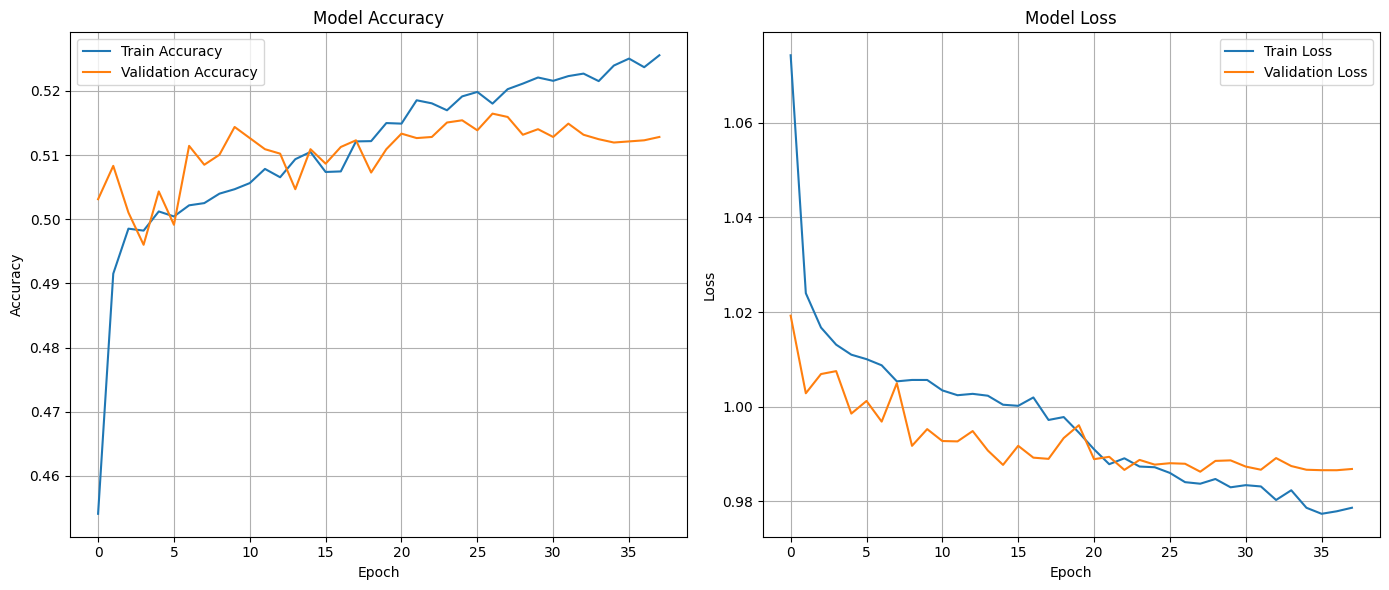

In [255]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.figure(figsize=(14, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


### Increasing model complexity

In [257]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/100
722/722 [==============================] - 6s 6ms/step - loss: 1.0649 - accuracy: 0.4569 - val_loss: 1.0129 - val_accuracy: 0.5009 - lr: 0.0010
Epoch 2/100
722/722 [==============================] - 3s 5ms/step - loss: 1.0289 - accuracy: 0.4886 - val_loss: 1.0136 - val_accuracy: 0.4979 - lr: 0.0010
Epoch 3/100
722/722 [==============================] - 3s 5ms/step - loss: 1.0195 - accuracy: 0.4953 - val_loss: 1.0038 - val_accuracy: 0.5057 - lr: 0.0010
Epoch 4/100
722/722 [==============================] - 3s 5ms/step - loss: 1.0190 - accuracy: 0.4958 - val_loss: 1.0064 - val_accuracy: 0.5047 - lr: 0.0010
Epoch 5/100
722/722 [==============================] - 4s 5ms/step - loss: 1.0140 - accuracy: 0.4974 - val_loss: 0.9952 - val_accuracy: 0.5078 - lr: 0.0010
Epoch 6/100
722/722 [==============================] - 4s 5ms/step - loss: 1.0132 - accuracy: 0.4973 - val_loss: 1.0111 - val_accuracy: 0.5064 - lr: 0.0010
Epoch 7/100
722/722 [==============================] - 4s 5ms/st

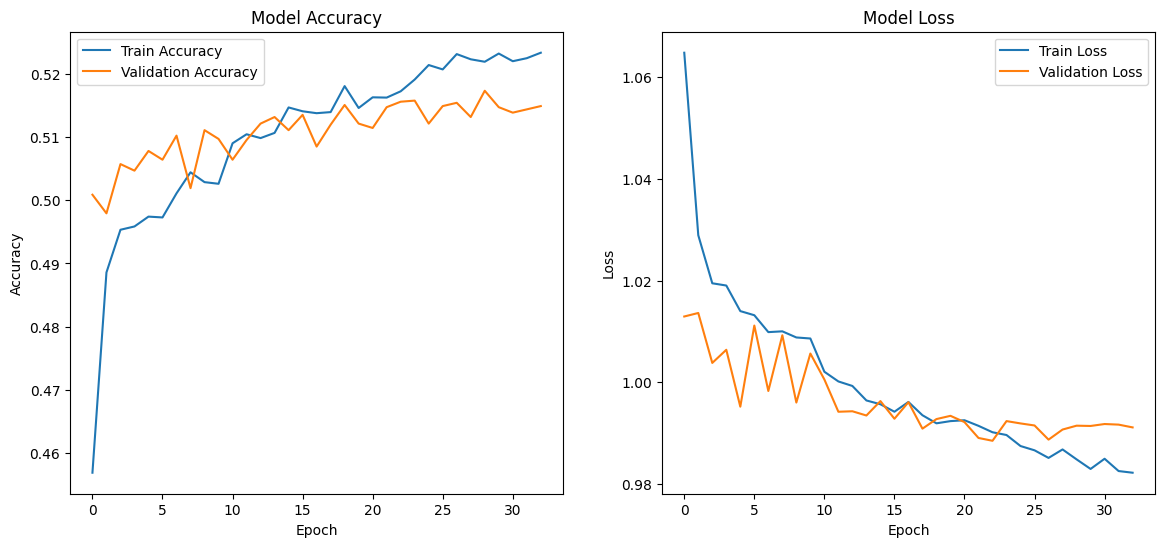

In [258]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [261]:
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from keras.optimizers import Adam

model = Sequential([
    Dense(512, input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.6),
    Dense(256),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.6),
    Dense(128),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.6),
    Dense(3, activation='softmax')
])

optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/100
722/722 [==============================] - 8s 7ms/step - loss: 1.4442 - accuracy: 0.3874 - val_loss: 1.0012 - val_accuracy: 0.5090 - lr: 1.0000e-04
Epoch 2/100
722/722 [==============================] - 4s 5ms/step - loss: 1.2998 - accuracy: 0.4164 - val_loss: 0.9996 - val_accuracy: 0.5050 - lr: 1.0000e-04
Epoch 3/100
722/722 [==============================] - 4s 5ms/step - loss: 1.2168 - accuracy: 0.4297 - val_loss: 0.9962 - val_accuracy: 0.5100 - lr: 1.0000e-04
Epoch 4/100
722/722 [==============================] - 4s 5ms/step - loss: 1.1536 - accuracy: 0.4353 - val_loss: 0.9971 - val_accuracy: 0.5081 - lr: 1.0000e-04
Epoch 5/100
722/722 [==============================] - 4s 5ms/step - loss: 1.1169 - accuracy: 0.4461 - val_loss: 0.9956 - val_accuracy: 0.5120 - lr: 1.0000e-04
Epoch 6/100
722/722 [==============================] - 4s 6ms/step - loss: 1.0840 - accuracy: 0.4579 - val_loss: 0.9955 - val_accuracy: 0.5102 - lr: 1.0000e-04
Epoch 7/100
722/722 [===================

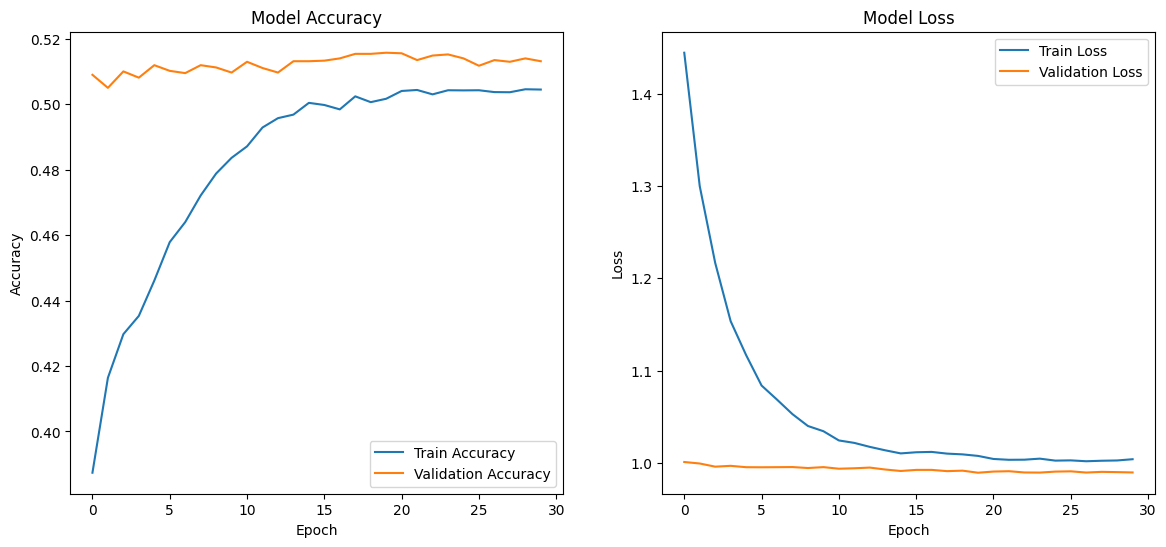

In [262]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Score prediction (home_team_goal_count, away_team_goal_count)

In [13]:
data

attendance    home_team_name    away_team_name  game_week  \
0        13155.00      Austria Wien  Wacker Innsbruck       1.00   
1        10785.00        Sturm Graz          Hartberg       1.00   
2         4523.00  Rheindorf Altach       Mattersburg       1.00   
3        11532.00          Salzburg         LASK Linz       1.00   
4         5200.00            Admira        Rapid Wien       1.00   
...           ...               ...               ...        ...   
37333     2555.27             Zorya   Kolos Kovalivka      30.00   
37334     2555.27          Polessya  Shakhtar Donetsk      30.00   
37335     2555.27     Obolon-Brovar       Oleksandria      30.00   
37336     2555.27            Hirnyk             Minai      30.00   
37337     2555.27      Chornomorets          Dnipro-1      30.00   

       home_team_goal_count  away_team_goal_count  total_goal_count  \
0                         2                     1                 3   
1                         3                     2                 5   
2                         2                     3                 5   
3                         3                     1                 4   
4                         0                     3                 3   
...                     ...                   ...               ...   
37333                     0                     1                 1   
37334                     2                     0                 2   
37335                     0                     3                 3   
37336                     3                     0                 3   
37337                     0                     2                 2   

       total_goals_at_half_time  home_team_goal_count_half_time  \
0                             2                               1   
1                             3                               2   
2                             2                               1   
3                             3                               3   
4                             3                               0   
...                         ...                             ...   
37333                         0                               0   
37334                         2                               2   
37335                         1                               0   
37336                         2                               2   
37337                         1                               0   

       away_team_goal_count_half_time  home_team_corner_count  \
0                                   1                       6   
1                                   1                       7   
2                                   1                       3   
3                                   0                       4   
4                                   3                       4   
...                               ...                     ...   
37333                               0                       9   
37334                               0                       5   
37335                               1                       4   
37336                               0                       6   
37337                               1                       4   

       away_team_corner_count  home_team_yellow_cards  home_team_red_cards  \
0                           1                       1                    0   
1                           6                       3                    0   
2                           9                       4                    0   
3                           4                       1                    0   
4                           5                       2                    0   
...                       ...                     ...                  ...   
37333                       2                       1                    0   
37334                       6                       1                    0   
37335                       2                    

In [14]:
#dropping leaking features
leaked_features_to_drop = [
    'home_team_goal_count',
    'away_team_goal_count',
    'total_goal_count',
    'total_goals_at_half_time',
    'home_team_goal_count_half_time',
    'away_team_goal_count_half_time',
    'home_team_corner_count',
    'away_team_corner_count',
    'home_team_yellow_cards',
    'home_team_red_cards',
    'away_team_yellow_cards',
    'away_team_red_cards',
    'home_team_first_half_cards',
    'home_team_second_half_cards',
    'away_team_first_half_cards',
    'away_team_second_half_cards',
    'home_team_shots',
    'away_team_shots',
    'home_team_shots_on_target',
    'away_team_shots_on_target',
    'home_team_shots_off_target',
    'away_team_shots_off_target',
    'home_team_fouls',
    'away_team_fouls',
    'home_team_possession',
    'away_team_possession',
    'home_team_xg',
    'away_team_xg',
    'corners_total',
    'yellow_cards_total',
    'red_cards_total',
    'cards_total',
    'shots_total',
    'shots_on_target_total',
    'shots_off_target_total',
    'fouls_total',
    'result'
]

In [16]:
X = data.drop(leaked_features_to_drop, axis=1)

In [17]:
X.shape

(36085, 133)

In [18]:
X.head()

attendance    home_team_name    away_team_name  game_week  \
0    13155.00      Austria Wien  Wacker Innsbruck       1.00   
1    10785.00        Sturm Graz          Hartberg       1.00   
2     4523.00  Rheindorf Altach       Mattersburg       1.00   
3    11532.00          Salzburg         LASK Linz       1.00   
4     5200.00            Admira        Rapid Wien       1.00   

   btts_percentage_pre_match  over_15_percentage_pre_match  \
0                          0                             0   
1                          0                             0   
2                          0                             0   
3                          0                             0   
4                          0                             0   

   over_25_percentage_pre_match  over_35_percentage_pre_match  \
0                             0                             0   
1                             0                             0   
2                             0                             0   
3                             0                             0   
4                             0                             0   

   over_45_percentage_pre_match  over_15_ht_fhg_percentage_pre_match  \
0                             0                                    0   
1                             0                                    0   
2                             0                                    0   
3                             0                                    0   
4                             0                                    0   

   over_05_ht_fhg_percentage_pre_match  over_15_2hg_percentage_pre_match  \
0                                    0                                 0   
1                                    0                                 0   
2                                    0                                 0   
3                                    0                                 0   
4                                    0                                 0   

   over_05_2hg_percentage_pre_match  average_corners_per_match_pre_match  \
0                                 0                                 0.00   
1                                 0                                 0.00   
2                                 0                                 0.00   
3                                 0                                 0.00   
4                                 0                                 0.00   

   average_cards_per_match_pre_match  odds_ft_home_team_win  odds_ft_draw  \
0                               0.00                   1.54          4.20   
1                               0.00                   1.49          4.30   
2                               0.00                   2.35          3.30   
3                               0.00                   1.44          4.30   
4                               0.00                   6.45          4.65   

   odds_ft_away_team_win  odds_ft_over15  odds_ft_over25  odds_ft_over35  \
0                   5.75            1.21            1.69            2.75   
1                   6.25            1.22            1.71            2.80   
2                   3.00            1.32            2.00            3.55   
3                   7.00            1.25            1.80            3.05   
4                   1.43            1.16            1.53            2.35   

   odds_ft_over45  odds_btts_yes  odds_btts_no   league        date      time  \
0            4.75           1.83          2.00  austria  2018-07-27  18:45:00   
1            4.25           1.95          1.87  austria  2018-07-28  15:00:00   
2            5.75           1.87          1.95  austria  2018-07-28  15:00:00   
3            4.25           2.10          1.77  austria  2018-07-29  15:00:00   
4            4.25           1.77          2.05  austria  2018-07-29  15:00:00   

  season  home_team_cumulative_goals_scored_pre_game  \
0  18/19                                    

In [20]:
len([col for col in X.columns if 'away' not in col])

81

## Home team model

In [267]:
home_team_features = [col for col in X.columns if 'away' not in col]

In [268]:
X_home = X[home_team_features]

In [269]:
X_home.shape

(36085, 80)

In [271]:
X_home.drop('const', axis=1, inplace=True)

C:\Users\Łukasz\AppData\Local\Temp\ipykernel_33156\3349698274.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_home.drop('const', axis=1, inplace=True)


In [278]:
num_features = X_home.select_dtypes(include='number').columns

In [279]:
X_home[num_features] = StandardScaler().fit_transform(X_home[num_features])

C:\Users\Łukasz\AppData\Local\Temp\ipykernel_33156\2649532679.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_home[num_features] = StandardScaler().fit_transform(X_home[num_features])


In [286]:
X_home = X_home.select_dtypes(include='number')

In [287]:
y_home = data['home_team_goal_count']

In [288]:
X_train, X_test, y_train, y_test = train_test_split(X_home, y_home, test_size=.2, random_state=42)

In [289]:
import xgboost as xgb

# Define the model
model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)

# Train the model
model.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

In [60]:
import joblib

# Save the model to disk
joblib.dump(model, 'xgb_home_model.pkl')  # Change filename for away model

['xgb_home_model.pkl']

In [291]:
from sklearn.metrics import mean_squared_error

# Predict on the testing set
preds = model.predict(X_test)

# Evaluate the predictions
mse = mean_squared_error(y_test, preds)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1.4830709122697179


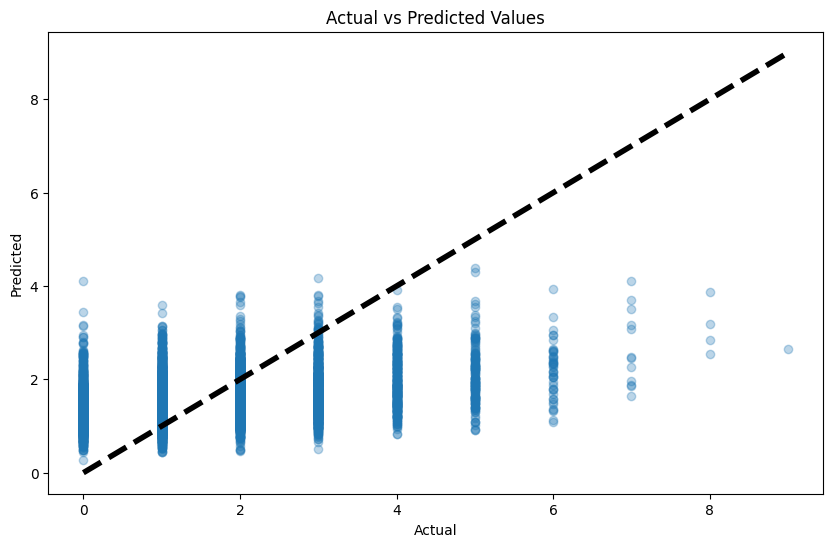

In [36]:
import matplotlib.pyplot as plt

# Plotting predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, preds, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
plt.show()


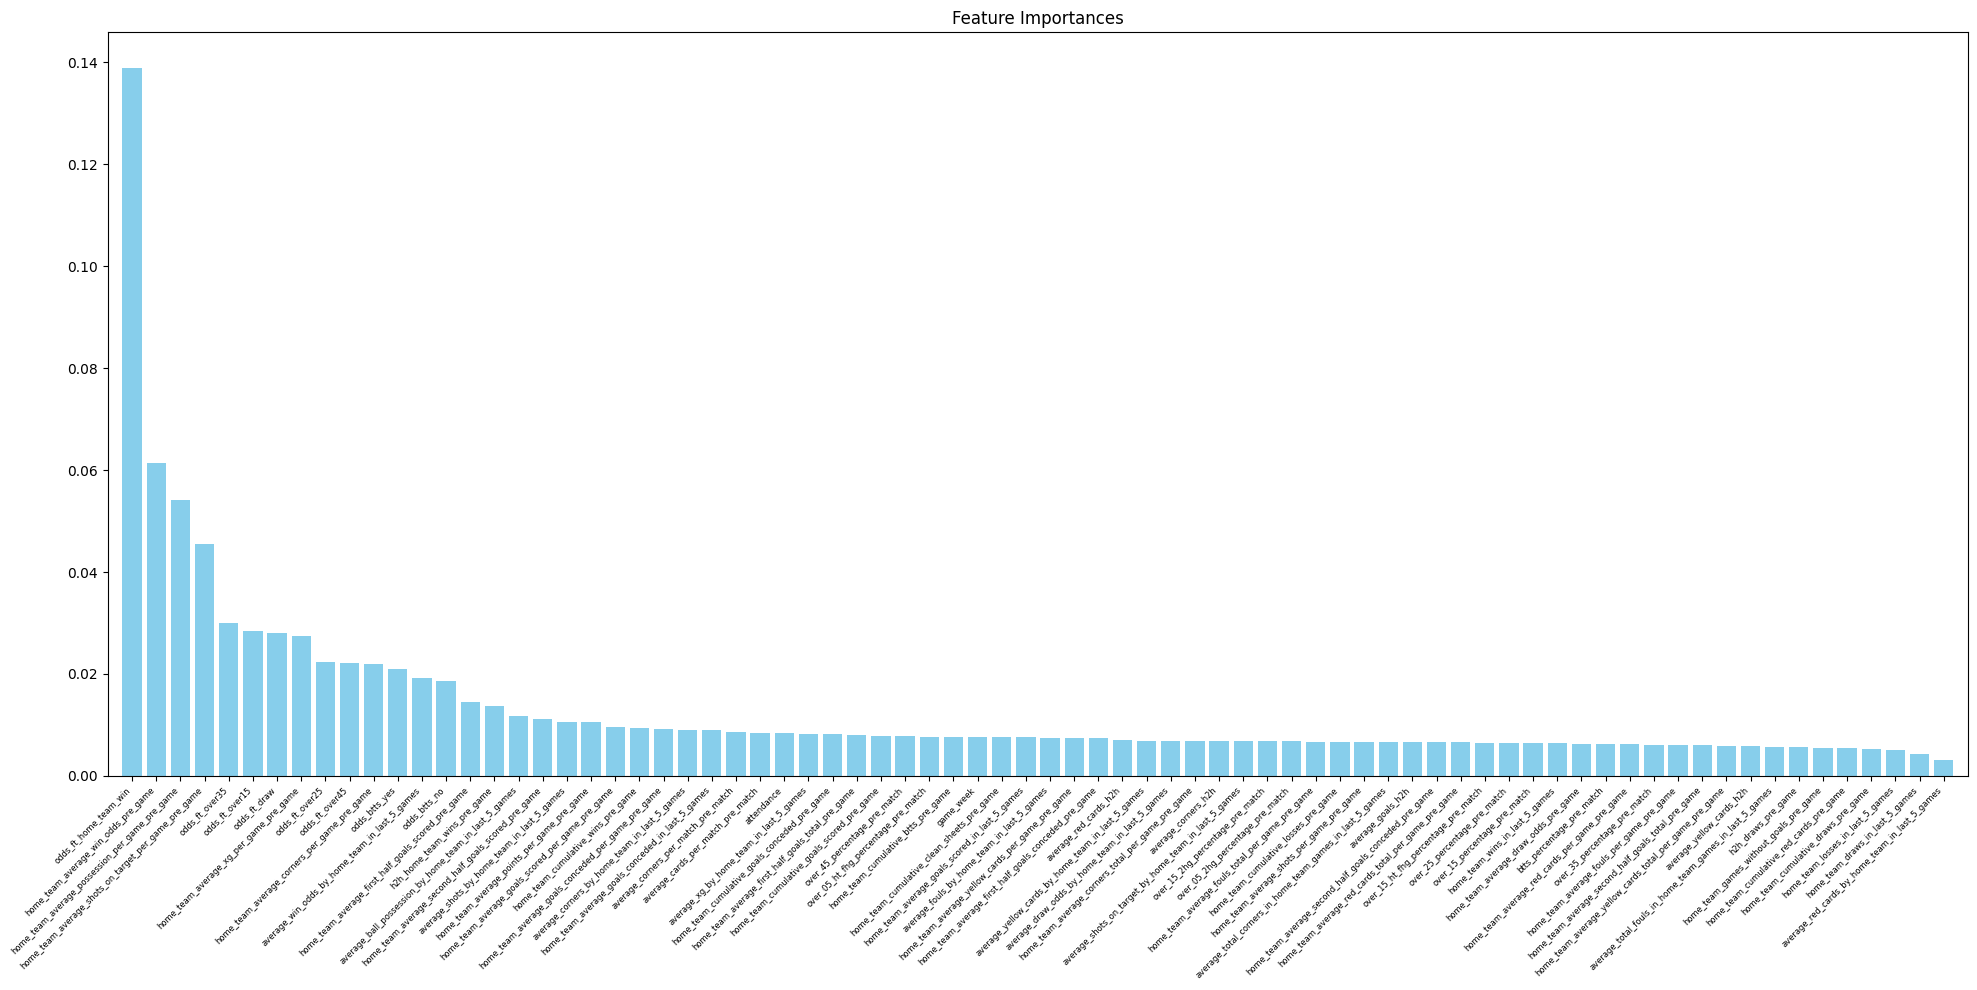

In [44]:
# Plotting feature importances
features = X_home.columns
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(20, 10))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], align='center', color='skyblue')
plt.xticks(range(X_train.shape[1]), [features[i] for i in indices], rotation=45, ha='right', fontsize=6)  # Rotate labels for better fit and adjust fontsize
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()


In [292]:
X_train, X_test, y_train, y_test = train_test_split(X_home, y_home, test_size=.2, random_state=42)

## XGBRegressor - hyperparameter tuning - home team goals

In [323]:
import optuna
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

def objective_xgbr(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-5, 10.0),
        'lambda': trial.suggest_float('lambda', 1e-5, 10.0)
    }
    
    model = XGBRegressor(**param, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    return rmse

In [324]:
study_xgbr = optuna.create_study(direction='minimize')
study_xgbr.optimize(objective_xgbr, n_trials=100)

print('Number of finished trials:', len(study_xgbr.trials))
print('Best trial:', study_xgbr.best_trial.params)

[I 2024-07-24 10:23:43,195] A new study created in memory with name: no-name-d504acb9-79e7-4f86-b69d-bc45029fc9ef
C:\Users\Łukasz\AppData\Local\Temp\ipykernel_33156\3576329706.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
[I 2024-07-24 10:23:46,679] Trial 0 finished with value: 1.2181227119538158 and parameters: {'n_estimators': 261, 'max_depth': 7, 'learning_rate': 0.006040493138921501, 'subsample': 0.6040380989104897, 'colsample_bytree': 0.9704917573787883, 'alpha': 1.2349965672927317, 'lambda': 6.592256418802336}. Best is trial 0 with value: 1.2181227119538158.
C:\Users\Łukasz\AppData\Local\Temp\ipykernel_33156\3576329706.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://githu

Number of finished trials: 100
Best trial: {'n_estimators': 912, 'max_depth': 3, 'learning_rate': 0.005206986536335056, 'subsample': 0.5975305485312352, 'colsample_bytree': 0.9059471647656043, 'alpha': 9.053439781011663, 'lambda': 1.086804740596587}


In [326]:
study_xgbr.best_value

1.2119139985499552

In [325]:
xgb_goals_best_params = study_xgbr.best_params
xgb_goals_best_params

{'n_estimators': 912,
 'max_depth': 3,
 'learning_rate': 0.005206986536335056,
 'subsample': 0.5975305485312352,
 'colsample_bytree': 0.9059471647656043,
 'alpha': 9.053439781011663,
 'lambda': 1.086804740596587}

## CatboostRegressor - hyperparameter tuning - home_team_goals

In [317]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
        'random_strength': trial.suggest_int('random_strength', 0, 100),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 100.0),
        'od_type': 'Iter',
        'od_wait': 50
    }
    model = CatBoostRegressor(**params, verbose=False)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50)
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    return rmse

study_catboost = optuna.create_study(direction='minimize')
study_catboost.optimize(objective_catboost, n_trials=100)
print('Best CatBoost parameters:', study_catboost.best_params)

[I 2024-07-24 10:04:29,767] A new study created in memory with name: no-name-e4b22ee7-2a8e-4bec-9222-9ca46e3c8121
C:\Users\Łukasz\AppData\Local\Temp\ipykernel_33156\2603100847.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
C:\Users\Łukasz\AppData\Local\Temp\ipykernel_33156\2603100847.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 100.0),
[I 2024-07-24 10:04:32,007] Trial 0 finished with value: 1.3137413554559891 and parameters: {'iterations': 217, 'depth': 5, 'learning_rate': 0.00017859368559670924, 'random_stre

Best CatBoost parameters: {'iterations': 806, 'depth': 8, 'learning_rate': 0.022847064189339523, 'random_strength': 0, 'bagging_temperature': 0.4475654928706755}


In [318]:
catboost_goals_best_params = study_catboost.best_params
catboost_goals_best_params

{'iterations': 806,
 'depth': 8,
 'learning_rate': 0.022847064189339523,
 'random_strength': 0,
 'bagging_temperature': 0.4475654928706755}

In [319]:
study_catboost.best_value

1.2112358370415157

## LGBMRegressor - hyperparameter tuning - home team goals

In [313]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import optuna

def objective_lgbmr(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "n_estimators": 1000,
        "verbosity": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return rmse

In [314]:
study_lgbmr = optuna.create_study(direction='minimize')
study_lgbmr.optimize(objective_lgbmr, n_trials=100)
print('Best CatBoost parameters:', study_lgbmr.best_params)

[I 2024-07-24 09:33:48,305] A new study created in memory with name: no-name-06bf1380-6c9f-4470-a077-423ccd37e824
[I 2024-07-24 09:33:56,783] Trial 0 finished with value: 1.2204343518281033 and parameters: {'learning_rate': 0.0017537999402692148, 'num_leaves': 66, 'subsample': 0.5813525284816605, 'colsample_bytree': 0.4660543935251625, 'min_data_in_leaf': 76}. Best is trial 0 with value: 1.2204343518281033.
[I 2024-07-24 09:34:06,241] Trial 1 finished with value: 1.2203297533972026 and parameters: {'learning_rate': 0.006873597007856843, 'num_leaves': 924, 'subsample': 0.2890840841344476, 'colsample_bytree': 0.33838134715002816, 'min_data_in_leaf': 67}. Best is trial 1 with value: 1.2203297533972026.
[I 2024-07-24 09:34:30,180] Trial 2 finished with value: 1.2260679515621946 and parameters: {'learning_rate': 0.0014990075941815248, 'num_leaves': 694, 'subsample': 0.3529918221597941, 'colsample_bytree': 0.38619867900625593, 'min_data_in_leaf': 28}. Best is trial 1 with value: 1.2203297533

Best CatBoost parameters: {'learning_rate': 0.002747921503429778, 'num_leaves': 193, 'subsample': 0.3460956679948684, 'colsample_bytree': 0.6700040449943433, 'min_data_in_leaf': 97}


In [321]:
study_lgbmr.best_value

1.2141186645165176

In [322]:
lgbmr_goals_best_params = study_lgbmr.best_params
lgbmr_goals_best_params

{'learning_rate': 0.002747921503429778,
 'num_leaves': 193,
 'subsample': 0.3460956679948684,
 'colsample_bytree': 0.6700040449943433,
 'min_data_in_leaf': 97}

## Away team model

In [327]:
away_team_features = [col for col in X.columns if 'home' not in col]

In [328]:
X_away = X[away_team_features]

In [329]:
X_away.drop('const', axis=1, inplace=True)

C:\Users\Łukasz\AppData\Local\Temp\ipykernel_33156\2245908840.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_away.drop('const', axis=1, inplace=True)


In [330]:
num_features = X_away.select_dtypes(include='number').columns

In [331]:
X_away[num_features] = StandardScaler().fit_transform(X_away[num_features])

C:\Users\Łukasz\AppData\Local\Temp\ipykernel_33156\1043513663.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_away[num_features] = StandardScaler().fit_transform(X_away[num_features])


In [332]:
X_away = X_away.select_dtypes(include='number')

In [333]:
y_away = data['away_team_goal_count']

In [334]:
X_train_away, X_test_away, y_train_away, y_test_away = train_test_split(X_away, y_away, test_size=.2, random_state=42)

## XGBRegressor - hyperparameter tuning - away team goals

In [335]:
import optuna
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

def objective_xgbr_away(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-5, 10.0),
        'lambda': trial.suggest_float('lambda', 1e-5, 10.0)
    }
    
    model = XGBRegressor(**param, random_state=42)
    model.fit(X_train_away, y_train_away)
    preds = model.predict(X_test_away)
    rmse = mean_squared_error(y_test_away, preds, squared=False)
    return rmse

In [338]:
study_xgbr_away = optuna.create_study(direction='minimize')
study_xgbr_away.optimize(objective_xgbr_away, n_trials=100)

print('Number of finished trials:', len(study_xgbr_away.trials))
print('Best trial:', study_xgbr_away.best_trial.params)

[I 2024-07-24 10:50:49,466] A new study created in memory with name: no-name-c156b6c1-7811-45c3-a693-c668f341073b
C:\Users\Łukasz\AppData\Local\Temp\ipykernel_33156\2933883155.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
[I 2024-07-24 10:51:22,690] Trial 0 finished with value: 1.0944539262685529 and parameters: {'n_estimators': 215, 'max_depth': 15, 'learning_rate': 0.056052253024333566, 'subsample': 0.8942723177615007, 'colsample_bytree': 0.967841916756869, 'alpha': 1.9120961692787473, 'lambda': 5.446780738453829}. Best is trial 0 with value: 1.0944539262685529.
C:\Users\Łukasz\AppData\Local\Temp\ipykernel_33156\2933883155.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://githu

Number of finished trials: 100
Best trial: {'n_estimators': 739, 'max_depth': 3, 'learning_rate': 0.00582530555363583, 'subsample': 0.8763945294011003, 'colsample_bytree': 0.9865084690237539, 'alpha': 0.6599981425394298, 'lambda': 0.1219602761550706}


In [340]:
study_xgbr_away.best_value

1.07241854186576

In [339]:
xgbr_away_goals_best_params = study_xgbr_away.best_params
xgbr_away_goals_best_params

{'n_estimators': 739,
 'max_depth': 3,
 'learning_rate': 0.00582530555363583,
 'subsample': 0.8763945294011003,
 'colsample_bytree': 0.9865084690237539,
 'alpha': 0.6599981425394298,
 'lambda': 0.1219602761550706}

## CatBoostRegressor - hyperparameter tuning - away team goals

In [341]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective_catboost_away(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
        'random_strength': trial.suggest_int('random_strength', 0, 100),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 100.0),
        'od_type': 'Iter',
        'od_wait': 50
    }
    model = CatBoostRegressor(**params, verbose=False)
    model.fit(X_train_away, y_train_away, eval_set=[(X_test_away, y_test_away)], early_stopping_rounds=50)
    preds = model.predict(X_test_away)
    rmse = mean_squared_error(y_test_away, preds, squared=False)
    return rmse

study_catboost_away = optuna.create_study(direction='minimize')
study_catboost_away.optimize(objective_catboost_away, n_trials=100)
# print('Best CatBoost parameters:', study_catboost_away.best_params)

[I 2024-07-24 11:08:11,088] A new study created in memory with name: no-name-5c10f022-a24e-4ede-bb6c-26e2ab8188c0
C:\Users\Łukasz\AppData\Local\Temp\ipykernel_33156\3333738149.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
C:\Users\Łukasz\AppData\Local\Temp\ipykernel_33156\3333738149.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 100.0),
[I 2024-07-24 11:08:15,182] Trial 0 finished with value: 1.1452194876136494 and parameters: {'iterations': 207, 'depth': 7, 'learning_rate': 6.63735091427427e-05, 'random_streng

In [343]:
study_catboost_away.best_value

1.0719925259263094

In [344]:
cb_goals_away_best_params = study_catboost_away.best_params
cb_goals_away_best_params

{'iterations': 477,
 'depth': 6,
 'learning_rate': 0.05830950674658578,
 'random_strength': 0,
 'bagging_temperature': 1.5458239927073953}

## LGBMRegressor - hyperparameter tuning - away team goals

In [345]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import optuna

def objective_lgbmr_away(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "n_estimators": 1000,
        "verbosity": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train_away, y_train_away)
    predictions = model.predict(X_test_away)
    rmse = mean_squared_error(y_test_away, predictions, squared=False)
    return rmse

In [346]:
study_lgbmr_away = optuna.create_study(direction='minimize')
study_lgbmr_away.optimize(objective_lgbmr_away, n_trials=100)
# print('Best CatBoost parameters:', study_lgbmr.best_params)

[I 2024-07-24 11:25:59,530] A new study created in memory with name: no-name-02a57571-d2ea-4f0e-abc0-0747c40f365f
[I 2024-07-24 11:26:14,371] Trial 0 finished with value: 1.0883976308987504 and parameters: {'learning_rate': 0.013725507077557016, 'num_leaves': 1011, 'subsample': 0.3257547132330944, 'colsample_bytree': 0.9356661472348473, 'min_data_in_leaf': 88}. Best is trial 0 with value: 1.0883976308987504.
[I 2024-07-24 11:26:25,788] Trial 1 finished with value: 1.094936749254563 and parameters: {'learning_rate': 0.021734510996079467, 'num_leaves': 785, 'subsample': 0.4386972149120134, 'colsample_bytree': 0.2690158701911434, 'min_data_in_leaf': 90}. Best is trial 0 with value: 1.0883976308987504.
[I 2024-07-24 11:26:44,321] Trial 2 finished with value: 1.090341178071237 and parameters: {'learning_rate': 0.01463385725895191, 'num_leaves': 789, 'subsample': 0.49353267907678794, 'colsample_bytree': 0.5466254952330177, 'min_data_in_leaf': 99}. Best is trial 0 with value: 1.08839763089875

In [348]:
study_lgbmr_away.best_value

1.0733164690834092

In [349]:
lgbmr_goals_away_best_params = study_lgbmr_away.best_params
lgbmr_goals_away_best_params

{'learning_rate': 0.002881489749228113,
 'num_leaves': 977,
 'subsample': 0.27270826320126973,
 'colsample_bytree': 0.9309650045774821,
 'min_data_in_leaf': 92}

In [57]:
import joblib

# Save the model to disk
joblib.dump(model, 'xgb_away_model.pkl')  # Change filename for away model

['xgb_away_model.pkl']

## Loading pretrained models

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.externals import joblib
from scipy.stats import poisson

In [61]:
home_model = joblib.load(r'xgb_home_model.pkl')
away_model = joblib.load(r'xgb_away_model.pkl')

In [70]:
home_goals_expected = home_model.predict(X_home)
away_goals_expected = away_model.predict(X_away)

In [71]:
# Generate Poisson distributions based on the predicted averages
max_goals = 9
score_matrix = np.zeros((max_goals+1, max_goals+1))

In [74]:
X_train_home, X_test_home, y_train_home, y_test_home = train_test_split(X_home, y_home, test_size=.2, random_state=42)
X_train_away, X_test_away, y_train_away, y_test_away = train_test_split(X_away, y_away, test_size=.2, random_state=42)

In [68]:
import numpy as np
from scipy.stats import poisson

# Assuming 'home_model' and 'away_model' are your trained models
# and 'X_home' and 'X_away' are your feature sets for the predictions

# Generate Poisson distributions based on the predicted averages
max_goals = 9
score_matrix = np.zeros((max_goals+1, max_goals+1))

for i in range(max_goals+1):
    for j in range(max_goals+1):
        home_prob = poisson.pmf(i, home_goals_expected)
        away_prob = poisson.pmf(j, away_goals_expected)
        score_matrix[i][j] = home_prob * away_prob

# Example usage: probability of a 2-1 home win
print(f"Probability of a 2-1 home win: {score_matrix[2][1]:.2%}")

ValueError: setting an array element with a sequence.

In [75]:
home_goals_expected = home_model.predict(X_test_home)
away_goals_expected = away_model.predict(X_test_away)

In [83]:
len(home_goals_expected)

7217

In [84]:
X_test

attendance  game_week  btts_percentage_pre_match  \
27849        0.00      21.00                         35   
10964      100.00       9.00                         75   
29162    39805.20      38.00                         59   
30468    14979.46      32.00                         50   
1270      2921.33      13.00                         67   
...           ...        ...                        ...   
261       7163.00      12.00                         54   
21195        0.00      17.00                         57   
25195    20862.75       6.00                         88   
19022     3155.69      31.00                         47   
21474     4394.50       7.00                         50   

       over_15_percentage_pre_match  over_25_percentage_pre_match  \
27849                            75                            50   
10964                            75                            63   
29162                            89                            70   
30468                            72                            53   
1270                             75                            67   
...                             ...                           ...   
261                              90                            45   
21195                            94                            69   
25195                            88                            88   
19022                            57                            44   
21474                           100                            34   

       over_35_percentage_pre_match  over_45_percentage_pre_match  \
27849                            20                            15   
10964                            13                            13   
29162                            53                            25   
30468                            41                            13   
1270                             33                            25   
...                             ...                           ...   
261                              35                             9   
21195                            38                            19   
25195                            75                            25   
19022                            14                            14   
21474                            34                             0   

       over_15_ht_fhg_percentage_pre_match  \
27849                                   30   
10964                                   25   
29162                                   47   
30468                                   32   
1270                                    42   
...                                    ...   
261                                     27   
21195                                   44   
25195                                   50   
19022                                   17   
21474                                   50   

       over_05_ht_fhg_percentage_pre_match  over_15_2hg_percentage_pre_match  \
27849                                   80                                40   
10964                                   63                                50   
29162                                   81                                67   
30468                                   66                                47   
1270                                    67                                67   
...                                    ...                               ...   
261                                     72                                39   
21195                                   88                                44   
25195                                   88                                75   
19022                                   80                                37   
21474                                   84                                50   

       over_05_2hg_percentage_pre_match  average_corners_per_match_pre_match  \
27849                                80       

In [76]:
import numpy as np
from scipy.stats import poisson

max_goals = 9
# Create a 3D array to hold probabilities for each match scenario if you have multiple matches
num_matches = len(home_goals_expected)  # Assuming the length is the number of matches
score_matrix = np.zeros((num_matches, max_goals+1, max_goals+1))

for match_index in range(num_matches):
    for i in range(max_goals+1):
        for j in range(max_goals+1):
            home_prob = poisson.pmf(i, home_goals_expected[match_index])
            away_prob = poisson.pmf(j, away_goals_expected[match_index])
            score_matrix[match_index][i][j] = home_prob * away_prob


In [358]:
home_goals = home_goals_expected[0]  # Assuming the first match
away_goals = away_goals_expected[0]
score_matrix = np.zeros((max_goals+1, max_goals+1))

for i in range(max_goals+1):
    for j in range(max_goals+1):
        home_prob = poisson.pmf(i, home_goals)
        away_prob = poisson.pmf(j, away_goals)
        score_matrix[i][j] = home_prob * away_prob

# Example usage: probability of a 2-1 home win
print(f"Probability of a 2-1 home win: {score_matrix[2][1]:.2%}")


Probability of a 2-1 home win: 8.03%


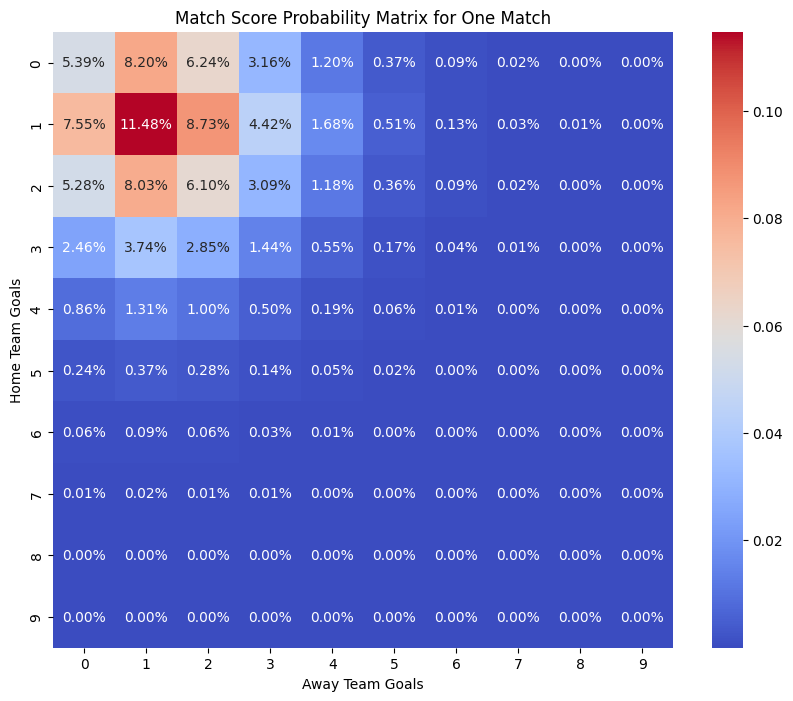

In [359]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(score_matrix, annot=True, fmt=".2%", cmap='coolwarm')
plt.title('Match Score Probability Matrix for One Match')
plt.xlabel('Away Team Goals')
plt.ylabel('Home Team Goals')
plt.show()


In [82]:
X.dtypes

attendance                                                  float64
home_team_name                                               object
away_team_name                                               object
game_week                                                   float64
btts_percentage_pre_match                                     int64
over_15_percentage_pre_match                                  int64
over_25_percentage_pre_match                                  int64
over_35_percentage_pre_match                                  int64
over_45_percentage_pre_match                                  int64
over_15_ht_fhg_percentage_pre_match                           int64
over_05_ht_fhg_percentage_pre_match                           int64
over_15_2hg_percentage_pre_match                              int64
over_05_2hg_percentage_pre_match                              int64
average_corners_per_match_pre_match                         float64
average_cards_per_match_pre_match               

In [264]:
X.to_csv('modelling_data/modelling_data.csv', index=False)